# EDA of Chatbot Arena Dataset 

The purpose of this notebook aims to explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. The EDA of Chatbot Arena Dataset will cover:
- Understanding the dataset structure and contents.
- Exploratory data analysis (EDA) of the data.
- Observations from EDA of the data to guide future modeling tasks.

## Understanding the Data
The source dataset comes from https://huggingface.co/datasets/lmsys/chatbot_arena_conversations. The author describes the dataset as follows:

> This dataset contains 33K cleaned conversations with pairwise human preferences. It is collected from 13K unique IP addresses on the Chatbot Arena from April to June 2023. Each sample includes a question ID, two model names, their full conversation text in OpenAI API JSON format, the user vote, the anonymized user ID, the detected language tag, the OpenAI moderation API tag, the additional toxic tag, and the timestamp.

### Main Dataset

- **Conversation Data**
You can find the processed dataset in `./chatbot-arena-conversations.jsonl.gz`. The dataset is in JSON line format and compressed using gzip. It has gone through the following preprocessing steps to make analysis easier:

    - Removed non-English conversations.
    - Removed conversations with more than one round.
    - Removed conversations classified as toxic or harmful.

The dataset you will be working with contains `25282` rows (out of `33000` total rows) and `7` columns. The columns are:

- `question_id`: A unique identifier for the question.
- `model_a`: The name of the first chatbot model.
- `model_b`: The name of the second chatbot model.
- `winner`: The name of the chatbot model that won the user vote.
- `judge`: The anonymized user ID that voted.
- `conversation_a`: The conversation between the user and `model_a`.
- `conversation_b`: The conversation between the user and `model_b`.

### Auxiliary Datasets

There are four auxiliary datasets that you can use to help with your analysis:

- **Embedding Data**
    - `./chatbot-arena-prompts-embeddings.npy` contains the 256-dimensional text embeddings for each of the human questions. The embeddings are generated using OpenAI’s text-embedding model. We will explain what embeddings are and how you can use them later.
    - `./chatbot-arena-model_a_response-embeddings.npy` contains the 256-dimensional text embeddings for each of the model a responses (second half of conversation a). The embeddings are generated using OpenAI’s text-embedding model. 
     - `./chatbot-arena-model_b_response-embeddings.npy` contains the 256-dimensional text embeddings for each of of the model b responses (second half of conversation b). The embeddings are generated using OpenAI’s text-embedding model.

- **Topic Modeling and Hardness Score Data**
- `./chatbot-arena-gpt3-scores.jsonl.gz` contains labels for the dataset, which you can use for later modeling tasks. It has the following fields:
  - **question_id**: The unique identifier for the question, as seen in `./chatbot-arena-conversations.jsonl.gz`.
  - **prompt**: The extracted human question. This is equivalent to the first message in `conversation_a` and `conversation_b` in `./chatbot-arena-conversations.jsonl.gz`.
  - **openai_scores_raw_choices_nested**: The response from OpenAI GPT 3.5 model. It contains:
    - The evaluated topic model
    - The reason for a hardness score (from 1 to 10)
    - The score value

  For each prompt, we have 3 responses from GPT 3.5 because it is a probabilistic model. In the real world, multiple annotators may provide different labels for ground truth data. We extracted the following fields into columns:

  - **topic_modeling_1, topic_modeling_2, topic_modeling_3**: Topic modeling for the first, second, and third response. Each topic contains two words.
  - **score_reason_1, score_reason_2, score_reason_3**: The reasons for the hardness score for the first, second, and third response.
  - **score_value_1, score_value_2, score_value_3**: The hardness score for the first, second, and third response.


# Exploratory Data Analysis

#### Loading the data
- Conversation Data
- Prompts and Models Response Embeddings
- Topic Modeling and Hardness Score Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style="whitegrid")

In [2]:
#---- Main Dataset ----#

# Conversation Data
conversation = pd.read_json(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)


#---- Auxiliary Datasets ----#

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

## Main Dataset - Conversations

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`).

In [3]:
display(conversation.head())

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [4]:
display(conversation.info())
display(conversation.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


None

(25282, 7)

#### Granularity and Cleaning
**Granularity**: the data is on the question-level. The dataset contains conversations from users with different chatbot models. In a row we can see one prompt from a user and the response from two chatbots models for that prompt. The specific models can be different for each conversation. All the columns contain qualitative nominal variables.

In [5]:
# Check for null values in data
conversation.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

**Null Values:** there are no null values in the data.

Next, lets create a winner_model column for easy analysis. For this, we will map 'tie' and 'tie (bothbad)' to just 'tie' string.

In [6]:
conversation['winner_model'] = conversation.apply(lambda row: row['model_a'] if row['winner'] == 'model_a' else (row['model_b'] if row['winner'] == 'model_b' else 'tie'), axis=1)

Let's check the structure of the conversation column.

In [7]:
conversation["conversation_a"].iloc[0]

[{'content': 'What is the difference between OpenCL and CUDA?',
  'role': 'user'},
 {'content': 'OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purpose并行编程接口 that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, and图形图像处理. The CUDA API provides a high-level, more efficient way to write parallel code that can run on top of a GPU, while still maintaining the ability to write code that can be easily adapted for other parallel computing platforms.',
  'role'

Lets extract out the prompt and chatbot model responses into separate columns. For this we will create separate columns for prompt_a & prompt_b and separate columns for models' reponse_a & response_b. We will also add columns for their length fields and a column for the winner_response.

In [8]:
conversation['conversation_a_user_prompt'] = conversation["conversation_a"].str[0].str["content"]
conversation['conversation_b_user_prompt'] = conversation["conversation_b"].str[0].str["content"]
conversation['user_prompt_length'] = conversation['conversation_a_user_prompt'].apply(len)
conversation['model_a_response'] = conversation['conversation_a'].apply(lambda x: x[1]['content'])
conversation['model_a_response_length'] = conversation['model_a_response'].apply(len)
conversation['model_b_response'] = conversation['conversation_b'].apply(lambda x: x[1]['content'])
conversation['model_b_response_length'] = conversation['model_b_response'].apply(len)
conversation['winner_response'] = conversation.apply(lambda row: row['model_a_response'] if row['winner'] == 'model_a' else (row['model_b_response'] if row['winner'] == 'model_b' else 'tie'), axis=1)
conversation['winner_response_length'] = conversation['winner_response'].apply(len)

Next, check if the user prompt is the same in all rows. If it is different in any row, we will need to fix that.

In [9]:
sum(conversation['conversation_a_user_prompt'] != conversation['conversation_b_user_prompt']) == 0

True

As we can see the user prompt is the same. That means we don't need both the columns we can drop one of them

In [10]:
conversation = conversation.drop(columns=['conversation_b_user_prompt'])
conversation = conversation.rename(columns={"conversation_a_user_prompt": "user_prompt"})

#### Cleaned Dataset
Lets look at the claned dataset

In [11]:
conversation.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,winner_model,user_prompt,user_prompt_length,model_a_response,model_a_response_length,model_b_response,model_b_response_length,winner_response,winner_response_length
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,koala-13b,What is the difference between OpenCL and CUDA?,47,OpenCL and CUDA are two different programming ...,892,OpenCL and CUDA are both programming languages...,1905,OpenCL and CUDA are both programming languages...,1905
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,tie,Why did my parent not invite me to their wedding?,49,It is possible that your parent did not invite...,660,It is likely that they wanted to keep the gues...,514,tie,3
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...",oasst-pythia-12b,"Fuji vs. Nikon, which is better?",32,Both Fuji and Nikon are popular camera brands ...,1114,This is a subjective question and the answer d...,1566,This is a subjective question and the answer d...,1566
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,oasst-pythia-12b,How to build an arena for chatbots?,35,Building an arena for chatbots can be done by ...,1575,Building an arena for chatbots is a great way ...,1624,Building an arena for chatbots is a great way ...,1624
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",vicuna-13b,When is it today?,17,"I'm sorry, I cannot determine the current date...",267,"Today is February 23, 2023.",27,"I'm sorry, I cannot determine the current date...",267


### Analysis

Now view the statistics of the prompt lengths

In [12]:
# View statistics for the prompt length
conversation['user_prompt_length'].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: user_prompt_length, dtype: float64

Since the median is less than the mean prompt length, this distribution is right skewed. Let's visualize this.

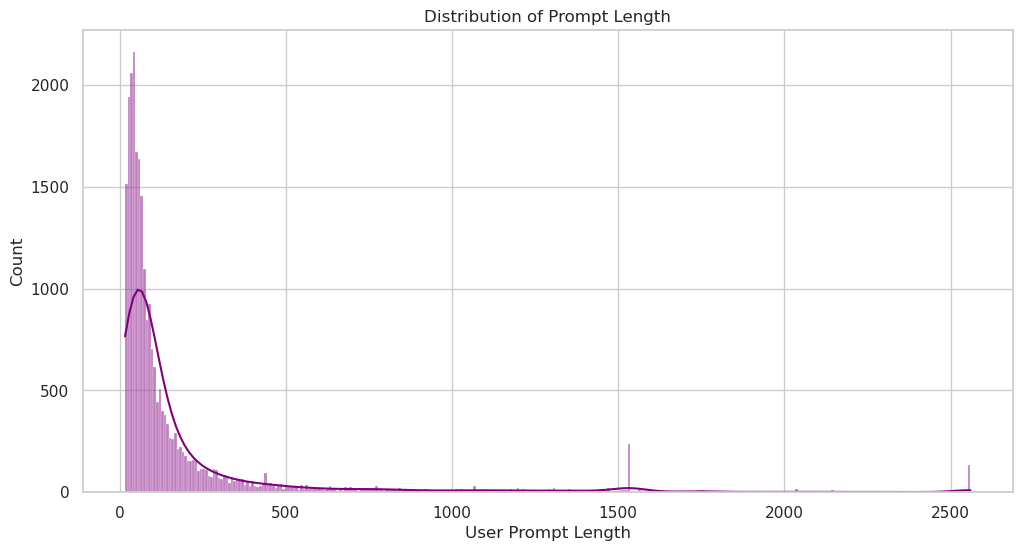

In [13]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(12, 6))
sns.histplot(conversation["user_prompt_length"], kde=True, color='purple')
plt.title("Distribution of Prompt Length")
plt.xlabel('User Prompt Length')
plt.show();

Let's apply this same process to the reponse length for models a and b.

In [14]:
# View statistics for the models' responses

display(conversation['model_a_response_length'].describe())

display(conversation['model_b_response_length'].describe())

count    25282.000000
mean       772.708409
std        655.798032
min          1.000000
25%        232.000000
50%        591.000000
75%       1215.750000
max       9857.000000
Name: model_a_response_length, dtype: float64

count    25282.000000
mean       773.163911
std        658.803491
min          1.000000
25%        232.000000
50%        582.000000
75%       1214.750000
max       7135.000000
Name: model_b_response_length, dtype: float64

Let's visualize the distribution

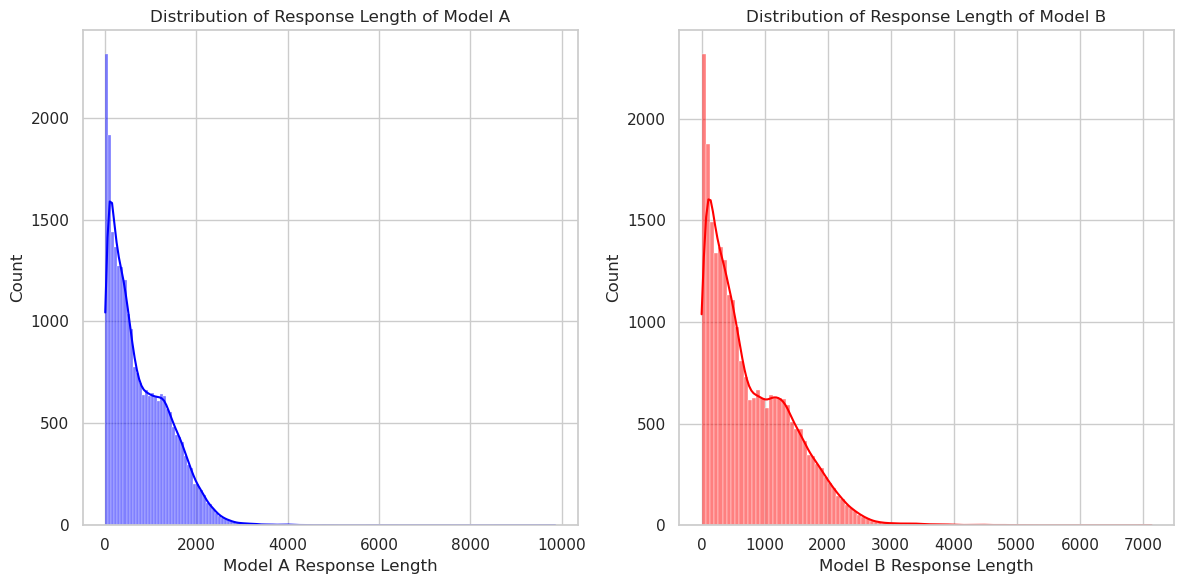

In [15]:
# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of the length of the response of model a.
sns.histplot(conversation["model_a_response_length"], ax=ax1, color='blue', kde=True)
ax1.set_title('Distribution of Response Length of Model A')
ax1.set_xlabel('Model A Response Length')

# Plot the distribution of the length of the response of model b.
sns.histplot(conversation["model_b_response_length"], ax=ax2, color='red', kde=True)
ax2.set_title('Distribution of Response Length of Model B')
ax2.set_xlabel('Model B Response Length')

# Adjust layout
plt.tight_layout()
plt.show()

**Takeaways**

- The distribution of user_prompt_length is heavily right-skewed, with the vast majority of prompts being very short. Most prompts fall below 500 characters, and only a few exceed 1000 characters, indicating that users tend to ask concise questions or make brief statements. The density around low values suggests most users short queries, likely without extensive context.
- Both model_a_response_length and model_b_response_length distributions are similarly right-skewed but extend further than the prompt length, reflecting that models tend to generate responses longer than the prompts. Most responses are below 1000 characters, but both models occasionally produce responses up to 4000 characters or more. This indicates that the models adapt to provide detailed responses when needed, though such cases are relatively rare.
- The shapes of the distributions for model_a_response_length and model_b_response_length are quite similar, with comparable peaks and tails, suggesting that both models generate responses of similar length distributions. The high count around the shorter lengths (<500 characters) in both models indicates a tendency to provide concise answers for most prompts, aligning with the user’s tendency to submit shorter queries.
- Both response distributions have some long-tail behavior, with a few responses exceeding 4000 characters. This likely represents instances where models generated detailed responses, possibly for complex or multi-part questions. The outliers indicate the models’ flexibility in producing longer responses when the prompt demands it, though these instances are rare.

Next, lets examine the **distribution of different chatbot models** (both model A and B) used in the conversations. 

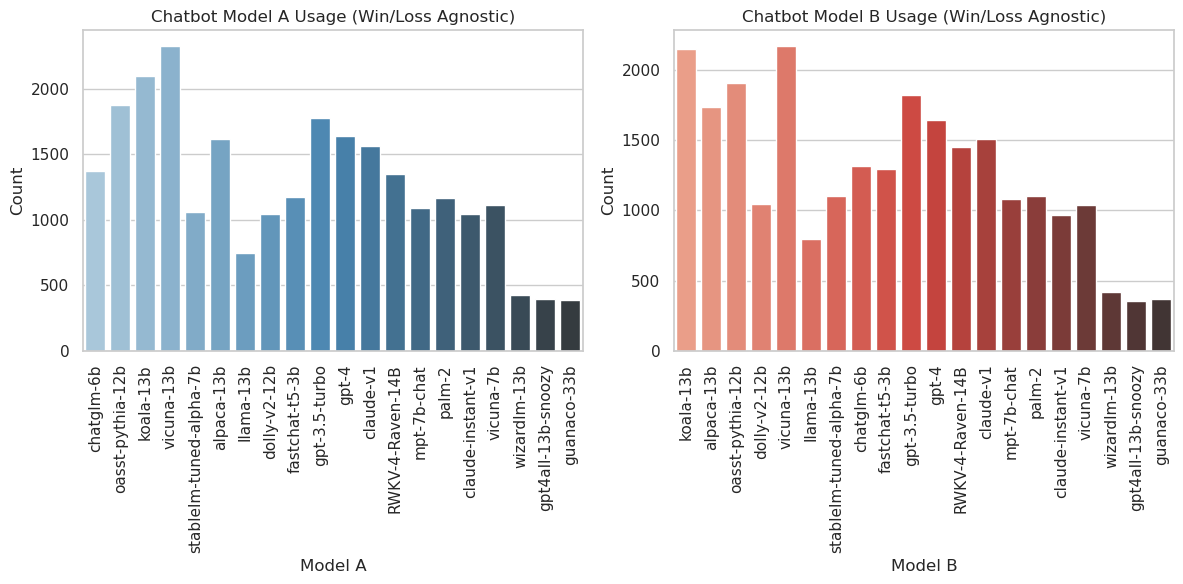

In [16]:
# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First bar chart
sns.countplot(data=conversation, x='model_a', ax=ax1, palette='Blues_d')
ax1.set_title('Chatbot Model A Usage (Win/Loss Agnostic)')
ax1.set_xlabel('Model A')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=90)

# Second bar chart
sns.countplot(data=conversation, x='model_b', ax=ax2, palette='Reds_d')
ax2.set_title('Chatbot Model B Usage (Win/Loss Agnostic)')
ax2.set_xlabel('Model B')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

Now lets check the **ranking of models** i.e. the distribution of the winner models.

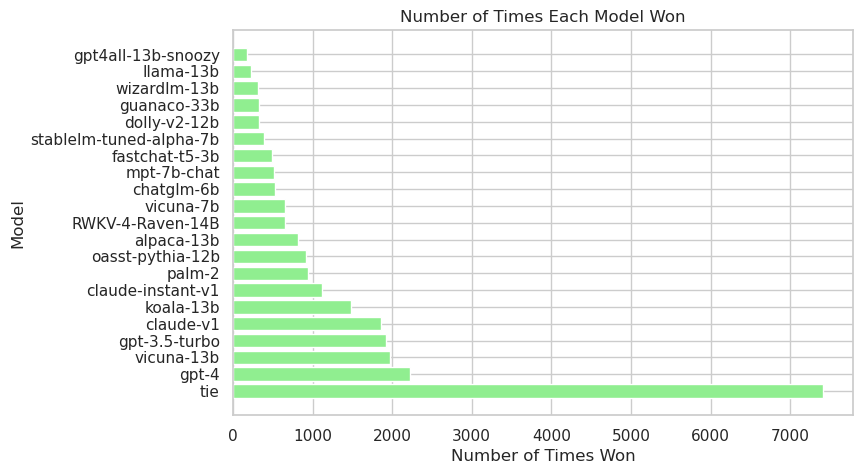

In [17]:
winners = conversation['winner_model'].value_counts()

plt.figure(figsize=(8, 5))
plt.barh(winners.index, winners.values, color='lightgreen')
plt.title('Number of Times Each Model Won')
plt.xlabel("Number of Times Won")
plt.ylabel("Model")
plt.show();

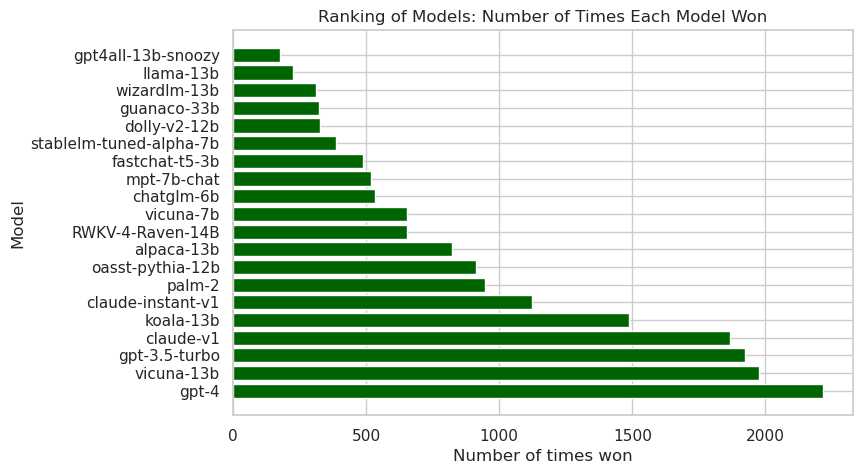

In [18]:
winners_without_tie_df = conversation[conversation['winner_model'] != 'tie']
winners_without_tie = winners_without_tie_df['winner_model'].value_counts()

plt.figure(figsize=(8, 5))
plt.barh(winners_without_tie.index, winners_without_tie.values, color='darkgreen')
plt.title('Ranking of Models: Number of Times Each Model Won')
plt.xlabel("Number of times won")
plt.ylabel("Model")
plt.show();

Get the win counts of the top-5 winning models.

In [19]:
# Determine the top five highest performing models based on win counts
top_models = winners_without_tie_df.groupby(["winner_model"]).size().reset_index(name = "win_count")
top_models = top_models.sort_values(by = "win_count", ascending = False).head()
top_models

,winner_model,win_count
8,gpt-4,2218
17,vicuna-13b,1974
7,gpt-3.5-turbo,1922
4,claude-v1,1865
11,koala-13b,1487


**Takeaways**
- GPT-4 has the highest win count overall, showing clear dominance. Vicuna-13b and GPT-3.5-turbo are also strong performers, ranking close behind GPT-4 in win counts. When ties are removed, these top models maintain their strong positions, indicating consistent performance in head-to-head comparisons.
- Ties occur frequently, with a significant portion of outcomes marked as ties, indicating that users often find models to be similarly effective.
- The top models by win count without ties are GPT-4, Vicuna-13b, GPT-3.5-turbo, Claude-v1, and Koala-13b. These models outperform the others consistently, suggesting that they provide more satisfying or accurate responses across diverse prompts.
- Models like GPT4All-13b-snoozy, Llama-13b, and Wizardlm-13b have very low win counts, suggesting they are less competitive in this environment.

Next, let's look at the **judge** column that contains the anonymized usernames who held the converstaion and picked the winner model.

In [20]:
len(conversation['judge'].unique())

10531

The dataset contains 10531. Let's check the distribution of number of conversations per user.

In [21]:
judge_value_counts = conversation['judge'].value_counts()
display(judge_value_counts)

display('Total users with more than 50 conversations: ' + str(len(judge_value_counts[judge_value_counts > 50])))

judge
arena_user_9965     307
arena_user_257      288
arena_user_13046    192
arena_user_3820     181
arena_user_15085    178
                   ... 
arena_user_11664      1
arena_user_11581      1
arena_user_11465      1
arena_user_8577       1
arena_user_21247      1
Name: count, Length: 10531, dtype: int64

'Total users with more than 50 conversations: 34'

Out of 10531 users, only 34 users have had more than 50 conversations. So we will get the top 20 users according to the number of conversations held and check the winner models that they frequently picked.

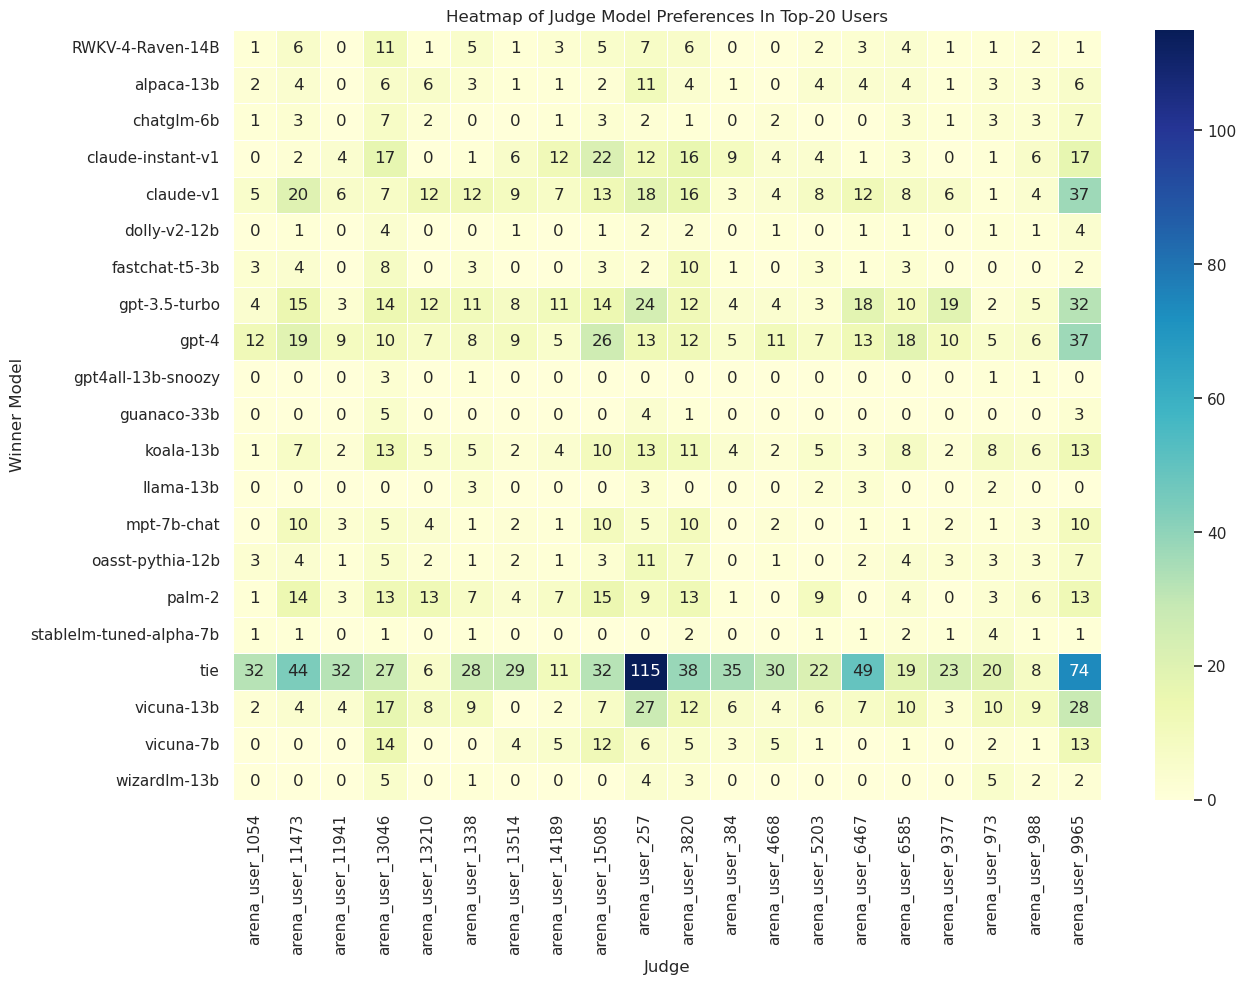

In [22]:
top20_users = conversation['judge'].value_counts()[:20].index
models_picked_by_top20_users = conversation[conversation['judge'].isin(top20_users)]
models_picked_by_top20_users_pivot = models_picked_by_top20_users.pivot_table(index='winner_model', columns='judge', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(models_picked_by_top20_users_pivot, annot=True, cmap="YlGnBu", fmt="d", linewidths=.5)
plt.title("Heatmap of Judge Model Preferences In Top-20 Users")
plt.xlabel("Judge")
plt.ylabel("Winner Model")
plt.show()

**Takeaways**
- Ties are common, with high counts in each judge’s choices (e.g., 115 ties by arena_user_13210), indicating frequent parity between models in responses.
- GPT-4, GPT-3.5-turbo, and Claude-v1 are among the most frequently chosen models, with high counts across several judges (e.g., GPT-4 has 22 wins with arena_user_11473). These models stand out as popular choices across different judges, reinforcing their strong performance.
- Some judges show distinct preferences. For example, arena_user_13210 selects Claude-v1 frequently (22 times), suggesting a possible personal bias or specific evaluation criteria. arena_user_15085 prefers GPT-4 and GPT-3.5-turbo more than other models, indicating consistency in these models' appeal.
- Models like GPT4All-13b-snoozy and Guanaco-33b are rarely chosen as winners, further highlighting their lower competitiveness.

Next, let's check model-pairing performace i.e. within the same pair of models, did some models consistently perform better.

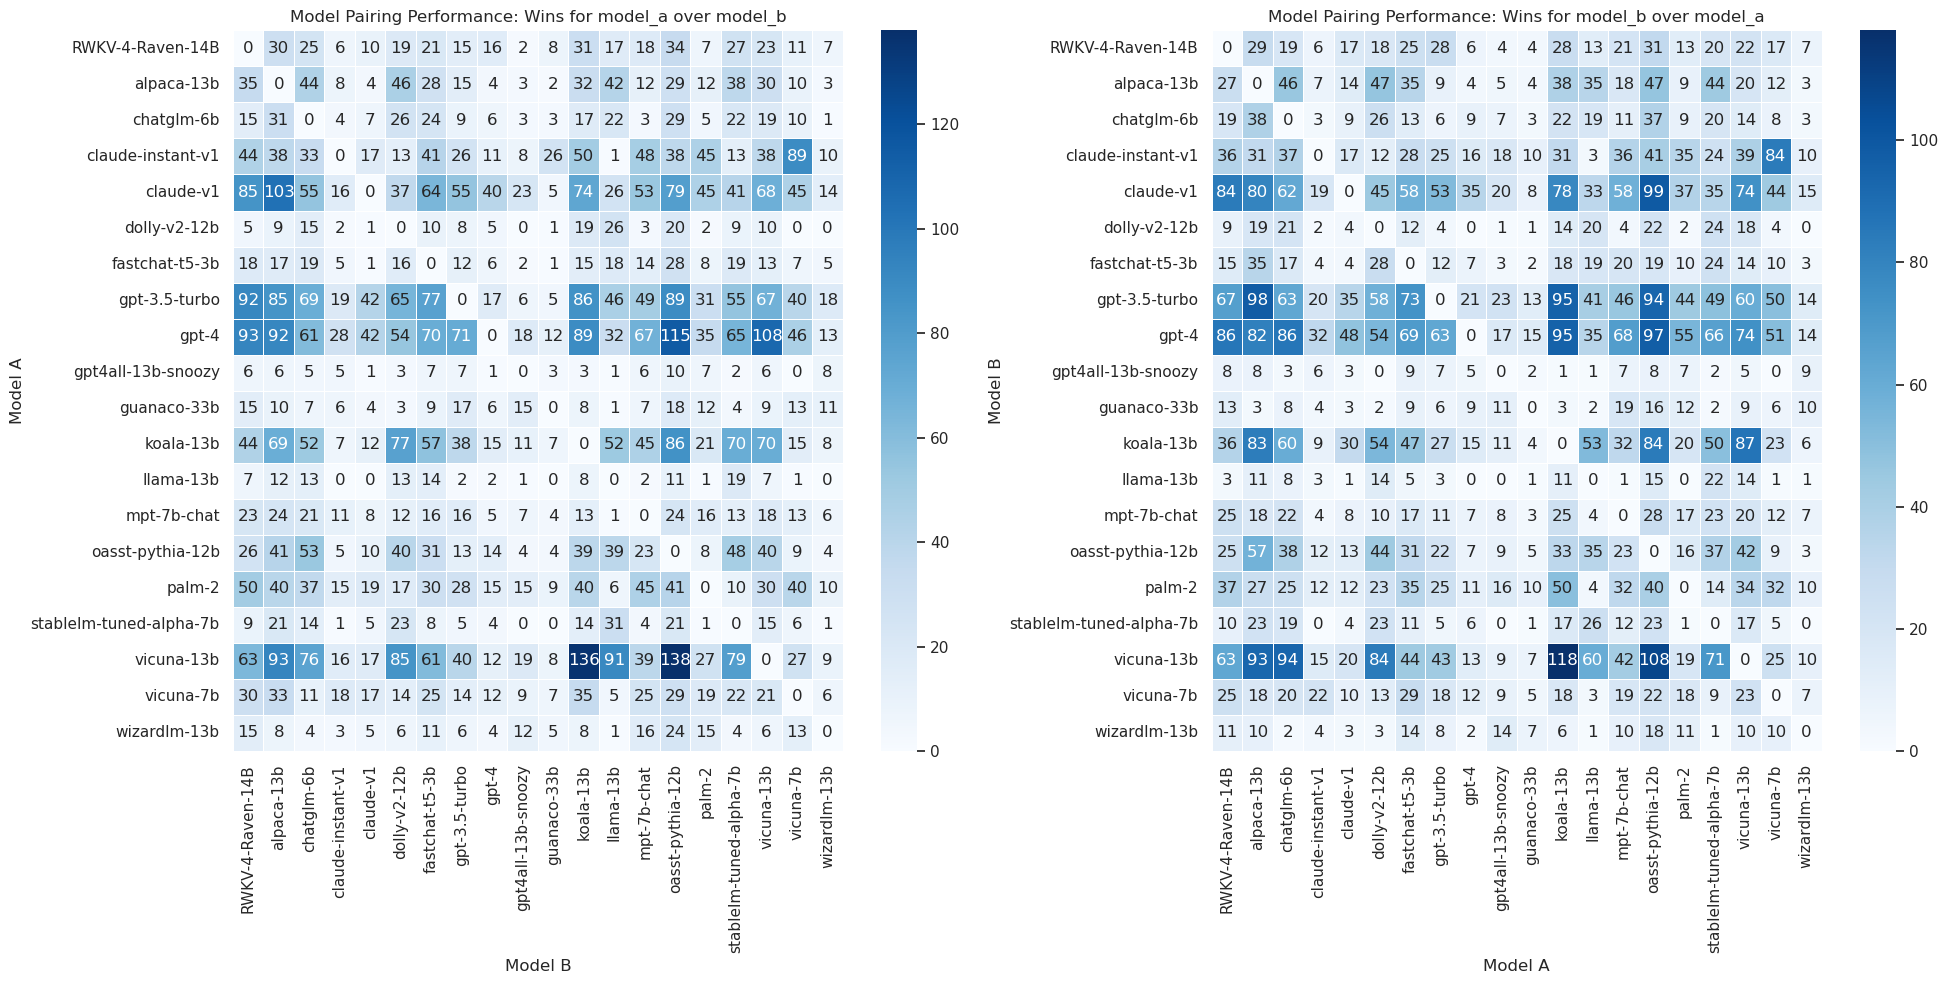

In [23]:
# Filter where model_a is the winner and create a count table
df_model_a_wins = winners_without_tie_df[winners_without_tie_df['winner_model'] == winners_without_tie_df['model_a']]
pairing_performance_a_over_b = df_model_a_wins.pivot_table(
    index='model_a', 
    columns='model_b', 
    aggfunc='size', 
    fill_value=0
)

# Filter where model_b is the winner and create a count table
df_model_b_wins = winners_without_tie_df[winners_without_tie_df['winner_model'] == winners_without_tie_df['model_b']]
pairing_performance_b_over_a = df_model_b_wins.pivot_table(
    index='model_b', 
    columns='model_a', 
    aggfunc='size', 
    fill_value=0
)

# Plot both heatmaps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for model_a wins over model_b
sns.heatmap(pairing_performance_a_over_b, annot=True, cmap="Blues", fmt="d", linewidths=.5, ax=ax1)
ax1.set_title("Model Pairing Performance: Wins for model_a over model_b")
ax1.set_xlabel("Model B")
ax1.set_ylabel("Model A")

# Heatmap for model_b wins over model_a
sns.heatmap(pairing_performance_b_over_a, annot=True, cmap="Blues", fmt="d", linewidths=.5, ax=ax2)
ax2.set_title("Model Pairing Performance: Wins for model_b over model_a")
ax2.set_xlabel("Model A")
ax2.set_ylabel("Model B")

plt.tight_layout()
plt.show()

Let's also visualize the average win rate of each model against all other models.

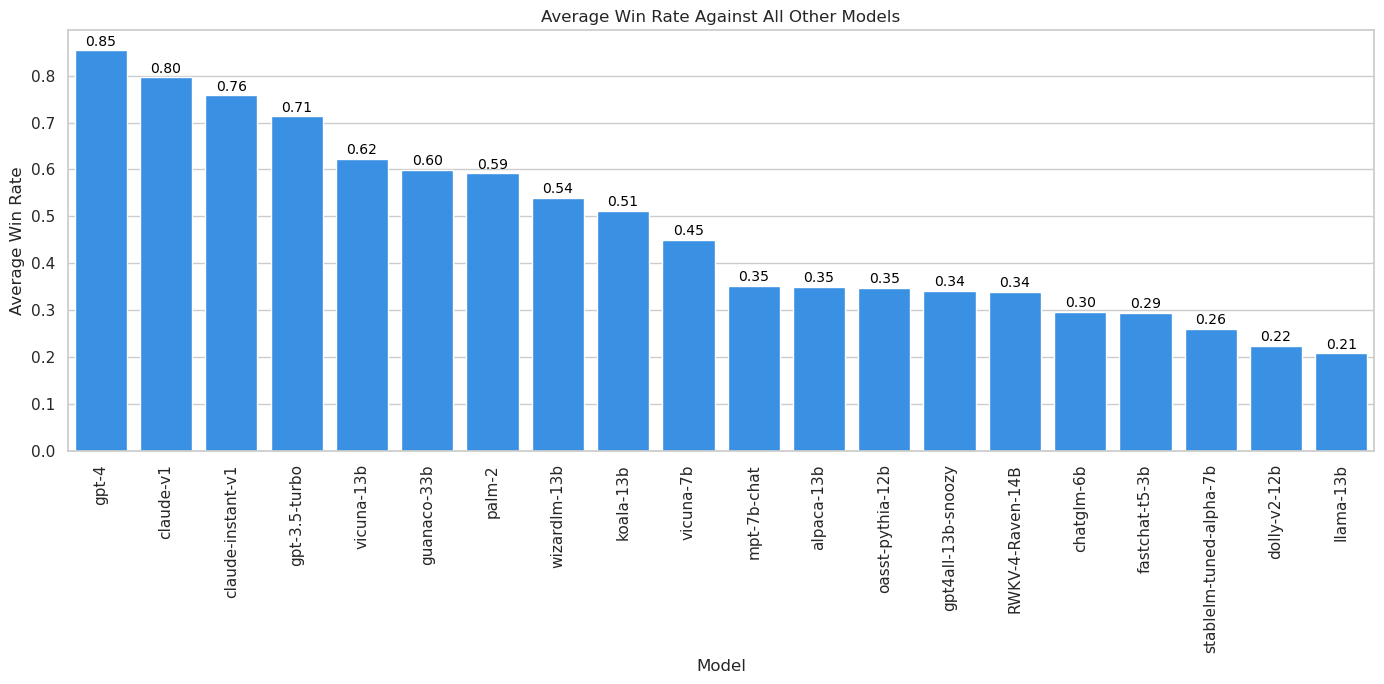

In [24]:
# Calculate the total wins for each model
win_counts = winners_without_tie_df['winner_model'].value_counts()

# Calculate the total appearances for each model (model_a + model_b counts)
model_a_counts = winners_without_tie_df['model_a'].value_counts()
model_b_counts = winners_without_tie_df['model_b'].value_counts()
total_matches = model_a_counts.add(model_b_counts, fill_value=0)

# Ensure both Series (win_counts and total_matches) have the same index
total_matches = total_matches.reindex(win_counts.index, fill_value=0)

# Compute the average win rate and handle any NaNs or infinities
average_win_rate = win_counts / total_matches
average_win_rate = average_win_rate.fillna(0)

# Prepare the DataFrame for plotting
win_rate_df = pd.DataFrame({
    'Model': average_win_rate.index,
    'Average Win Rate': average_win_rate.values
})

# Sort the DataFrame by win rate for better visualization
win_rate_df = win_rate_df.sort_values(by='Average Win Rate', ascending=False)

# Plot the bar chart
plt.figure(figsize=(14, 7))
sns.barplot(data=win_rate_df, x='Model', y='Average Win Rate', color='dodgerblue')

# Add labels on top of each bar
for i in range(len(win_rate_df)):
    rate = win_rate_df['Average Win Rate'].iloc[i]
    # Only add labels if they are finite values
    if np.isfinite(rate):
        plt.text(i, rate + 0.01, f"{rate:.2f}", ha='center', color='black', fontsize=10)

# Customize the plot
plt.title('Average Win Rate Against All Other Models')
plt.xlabel('Model')
plt.ylabel('Average Win Rate')
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

**Takeaways**

We have the following takeaways from the two heatmaps above:

1. Consistently Strong Models 
- GPT-4: This model stands out with high win counts against a wide range of opponents. For example:
    - GPT-4 vs GPT-3.5-turbo: GPT-4 won 115 times when it was model_a and 95 times as model_b. This suggests a strong advantage over GPT-3.5-turbo in head-to-head comparisons.
    - GPT-4 vs Claude-v1: Similarly, GPT-4 won 89 times as model_a and 78 times as model_b, indicating it consistently outperformed Claude-v1 regardless of its role.
- Vicuna-13b: Another high-performing model, Vicuna-13b shows significant wins against many models.
    - Vicuna-13b vs GPT-3.5-turbo: Vicuna-13b won 85 times as model_a and 73 times as model_b, illustrating its reliability in this matchup.
    - Vicuna-13b vs Claude-v1: This model also performed well against Claude-v1, winning 61 times as model_a and 58 times as model_b.

3. Consistently Weaker Models: GPT4All-13b-Snoozy and Guanaco-33b have some of the lowest win counts across both heatmaps, indicating that they are generally less competitive.
- GPT4All-13b-Snoozy: Wins only occasionally, such as 6 times against Claude-v1 when it was model_b, and 5 times against GPT-3.5-turbo as model_a. Overall, it struggles against most models.
- Guanaco-33b Shows similar weaknesses, with wins as low as 3 against GPT-4 as model_b, and only 5 times against Claude-instant-v1 as model_a. This low win count across pairings suggests it may lack robustness or versatility.

4. Models From The Same Series
- PT-3.5-turbo vs GPT-4: This pairing is particularly interesting, as GPT-4 shows a clear advantage, but GPT-3.5-turbo still manages some wins. As model_b GPT-3.5-turbo won 63 times against GPT-4, indicating it can occasionally outperform GPT-4 depending on the context or prompt. This matchup suggests that while GPT-4 is generally stronger, GPT-3.5-turbo may have certain contexts or types of conversations where it competes well.
- Claude-v1 vs Claude-instant-v1: Both models from the Claude family, but Claude-v1 shows consistently higher win counts. Claude-v1 won 55 times as model_a against Claude-instant-v1 and 45 times as model_b. This suggests that Claude-v1 might be a more robust model than Claude-instant-v1, even though they belong to the same family.

5. Asymmetrical Pairing Performance: the asymmetrical results suggest that some models might perform differently depending on their position (model_a vs. model_b). This could be due to variations in prompt handling, response strategies, or even random fluctuations in performance. we will explore this further later in our EDA.
- laude-v1 vs Vicuna-13b: In this pairing, Claude-v1 performs relatively well when it’s model_b, winning 58 times, compared to 61 wins for Vicuna-13b. However, when Claude-v1 is model_a, Vicuna-13b wins significantly more frequently, with 85 wins compared to 40 for Claude-v1.
- GPT-3.5-turbo vs Claude-instant-v1: When GPT-3.5-turbo is model_a, it wins 42 times compared to 18 wins for Claude-instant-v1. But when Claude-instant-v1 is model_a, it wins more often, with 33 wins versus 30 for GPT-3.5-turbo.

Next, let's analyze the response of the top-5 winnings models and of the best model.

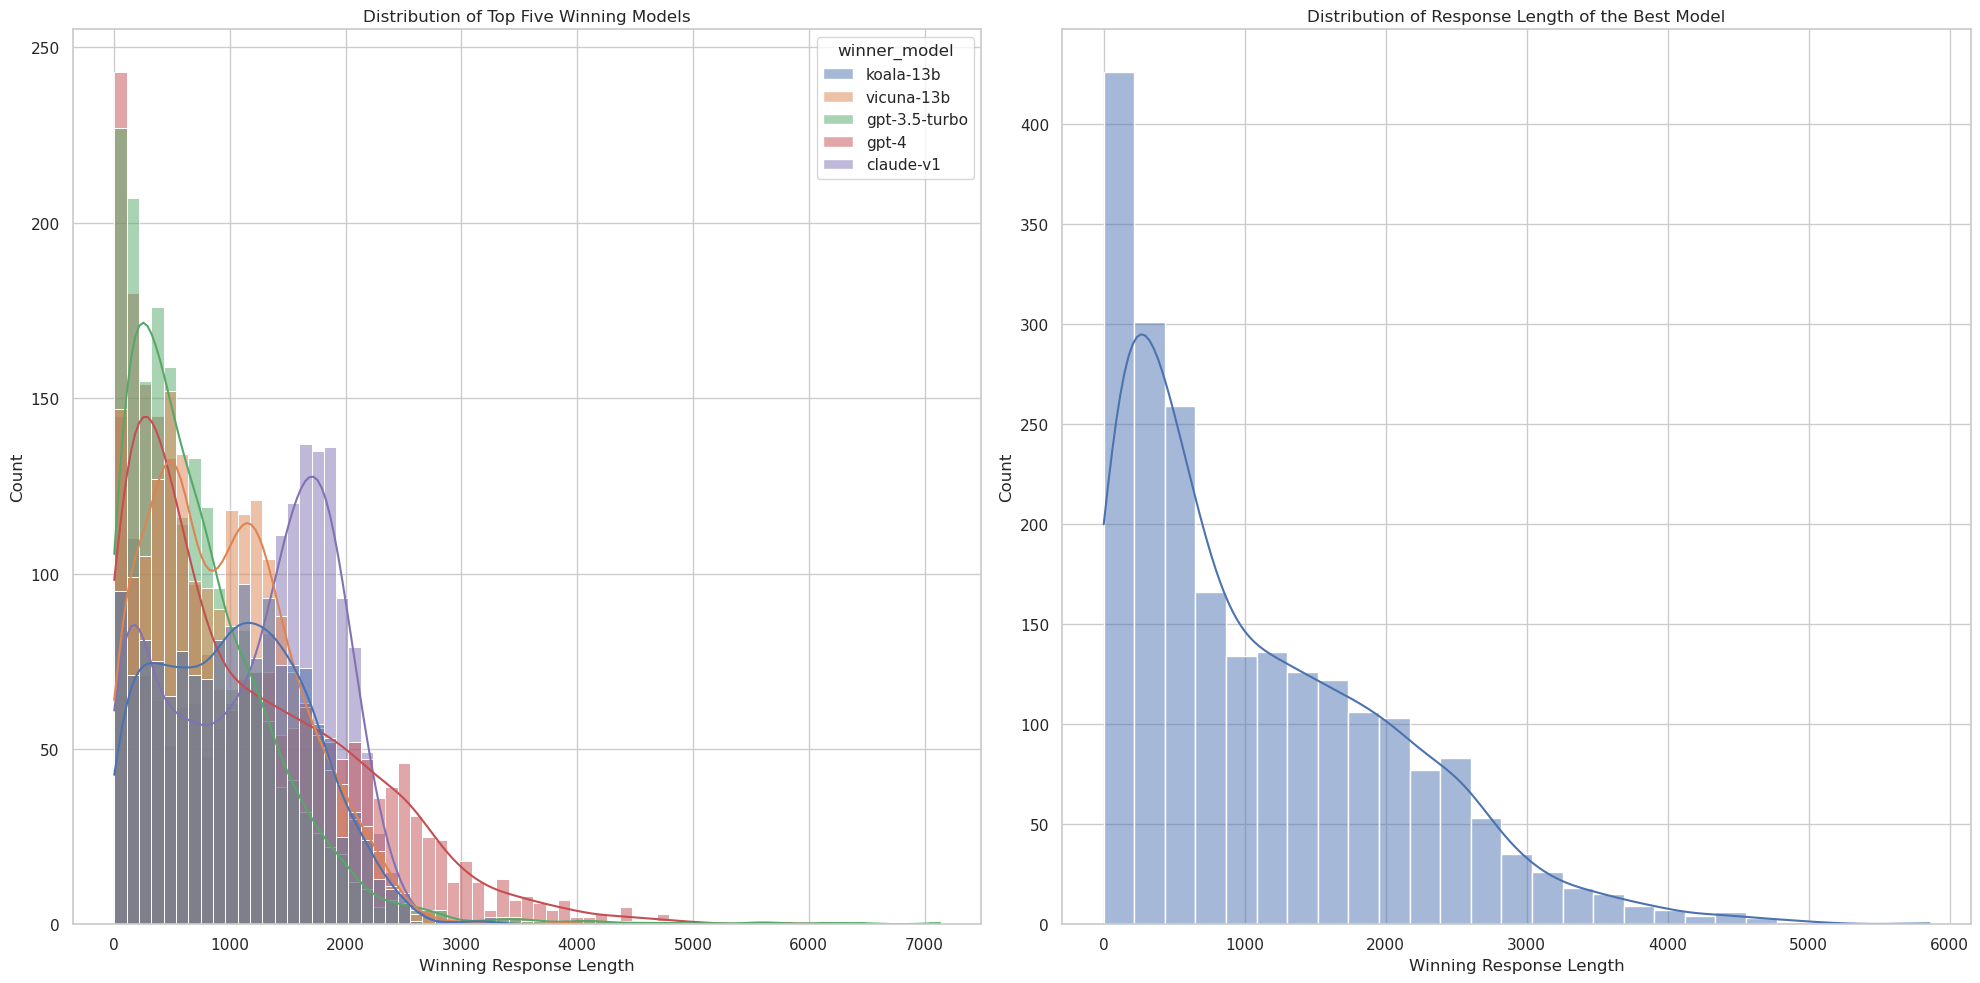

In [25]:
# Filter the top models to only include the top five models
top_five = list(top_models["winner_model"])
df_top_five = winners_without_tie_df[winners_without_tie_df["winner_model"].isin(top_five)]
best_model = winners_without_tie_df[winners_without_tie_df["winner_model"] == 'gpt-4']

# Set up the subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First histogram
sns.histplot(data = df_top_five, x = "winner_response_length", hue = "winner_model", kde = True, ax=ax1)
ax1.set_title("Distribution of Top Five Winning Models")
ax1.set_xlabel("Winning Response Length")

# Second histogram
sns.histplot(best_model["winner_response_length"], kde=True, ax=ax2)
ax2.set_title("Distribution of Response Length of the Best Model")
ax2.set_xlabel("Winning Response Length")

# Adjust layout
plt.tight_layout()
plt.show()

**Takeaways**
- All top 5 winning models have right-skewed distributions, with most responses clustering below 1000 characters. This indicates a user preference for concise answers across models. However, to confirm that we still need to check the distribution of the loser model responses to see if there is a difference.

Let's also check the summary statistics of winner and loser models side-by-side w.r.t the response lengths.

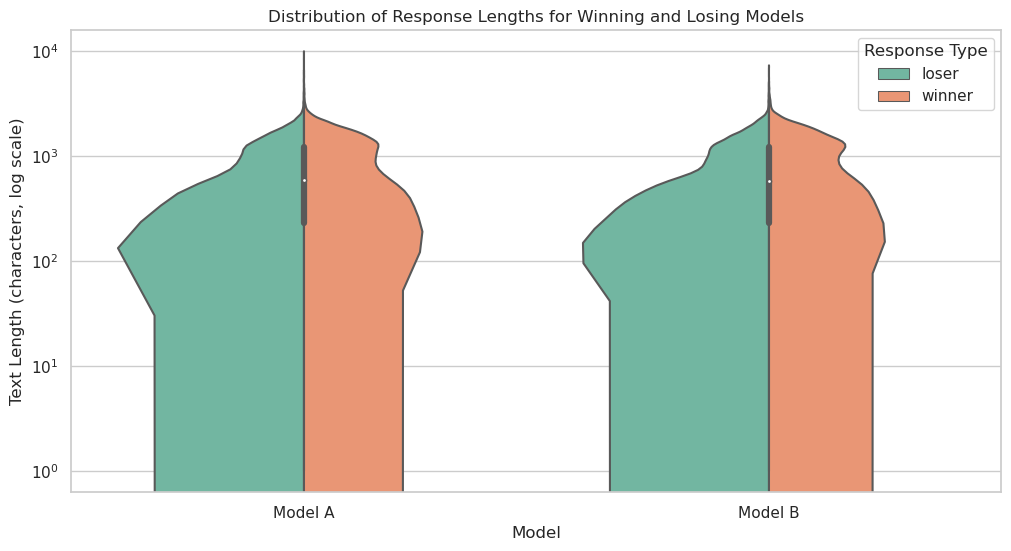

In [26]:
violit_plot_conversation_copy = conversation.copy()

# Create a column indicating whether each response is from the winning or losing model
violit_plot_conversation_copy['model_a_win'] = violit_plot_conversation_copy['winner_model'] == violit_plot_conversation_copy['model_a']
violit_plot_conversation_copy['model_b_win'] = violit_plot_conversation_copy['winner_model'] == violit_plot_conversation_copy['model_b']

# Add columns indicating if the response is from the winner or loser
violit_plot_conversation_copy['model_a_response_type'] = violit_plot_conversation_copy['model_a_win'].apply(lambda x: 'winner' if x else 'loser')
violit_plot_conversation_copy['model_b_response_type'] = violit_plot_conversation_copy['model_b_win'].apply(lambda x: 'winner' if x else 'loser')

# Reshape the DataFrame for plotting
lengths_df = pd.DataFrame({
    'Length': violit_plot_conversation_copy['model_a_response_length'].tolist() + violit_plot_conversation_copy['model_b_response_length'].tolist(),
    'Type': violit_plot_conversation_copy['model_a_response_type'].tolist() + violit_plot_conversation_copy['model_b_response_type'].tolist(),
    'Model': ['Model A'] * len(violit_plot_conversation_copy) + ['Model B'] * len(violit_plot_conversation_copy)
})

# Plotting the violin plot with response lengths separated by winner/loser status
plt.figure(figsize=(12, 6))
sns.violinplot(x='Model', y='Length', hue='Type', data=lengths_df, palette='Set2', split=True)
plt.yscale('log')  # Log scale to accommodate length variability
plt.title("Distribution of Response Lengths for Winning and Losing Models")
plt.xlabel("Model")
plt.ylabel("Text Length (characters, log scale)")
plt.legend(title="Response Type")
plt.show()

**Takeaways**
- This negates our earlier belief that only winner models have shorter response length. We can see that Both Model A and Model B show overlapping distributions for winners and losers, indicating that response length alone does not determine winning or losing. The models produce similar-length responses regardless of outcome.
- However, we do see that winners have a slightly wider spread in length, especially in the higher range (10^3 characters or more). This suggests that winning responses may sometimes be more elaborate or detailed but not consistently so.
- The similarity in distribution shape for both Model A and Model B implies that both models respond with comparable verbosity, regardless of whether they win or lose.

### Key Observations and Takeaways From Conversation Dataset

- **Do arena users ask long or short questions? What is the average length of prompts users give to the chatbots?**
Most users ask pretty short questions, with prompt lengths heavily skewed toward the shorter end—under 500 characters. Very few prompts go beyond 1000 characters, which suggests that users tend to ask straightforward questions or make simple statements without too much detail.

- **Describe the length of the response for models in general. In general, what is the average response length for a model?**
Both `model_a_response_length` and `model_b_response_length` show similar right-skewed distributions, generally producing responses longer than the prompts. Most responses are under 1000 characters, but some reach up to 4000 characters, indicating that the models are capable of generating more detailed responses when needed.

- **What are the top five models based on winning from either model a or model b?**
The top five winning models are GPT-4, Vicuna-13b, GPT-3.5-turbo, Claude-v1, and Koala-13b. These models consistently outperform others in head-to-head comparisons, showing they’re able to handle diverse prompts well.

- **Describe the distribution of the top five models based solely on wins. What is the average response length of the top five models compared to models in general?**
or the top five models, response lengths show a similar right-skewed pattern, with most responses under 1000 characters. GPT-4, however, stands out a bit with a wider range, showing it can produce more detailed responses when needed, which may contribute to its high win rate.

- **What is the best model based solely on wins? Describe its distribution and compare its statistics versus the general case of the top five models.**
GPT-4 is identified as the best model based on win count. Its response length distribution is similar to the other top models but shows a broader range, especially on the longer side. This flexibility in producing both concise and detailed answers may be a factor in its consistent wins.

- **Does response length alone determine winning or losing?**
Response length by itself doesn’t seem to make or break a win. Both `Model A` and `Model B` show similar response length patterns for winners and losers, suggesting that other factors—like response quality—probably play a bigger role. That said, winning responses sometimes have a slightly wider spread in length, especially at the upper end.

- **How frequently do ties occur, and what might this indicate about model performance?**
Ties are fairly common, with certain judges choosing "tie" often. This points to a lot of instances where models perform similarly, suggesting that both may be providing equally useful or relevant responses.

- **Are there judge-specific preferences or biases?**
Yes, some judges do show clear favorites. For example, `arena_user_13210` often picks Claude-v1, while `arena_user_15085` leans towards GPT-4 and GPT-3.5-turbo. This could hint at personal biases or just consistent preferences for certain response styles based on the topics they're interested in

- **Which models are consistently strong or weak across different pairings?**
GPT-4** and Vicuna-13b are strong performers, winning against many other models across the board. On the flip side, models like GPT4All-13b-snoozy and Guanaco-33b rarely win, which suggests they struggle to keep up with the competition. GPT-4 stands out with strong results against GPT-3.5-turbo and Claude-v1, showing a clear competitive edge.

- **Do models from the same family (e.g., Claude-v1 vs Claude-instant-v1) perform similarly?**
Not always. While Claude-v1 and Claude-instant-v1 come from the same family, Claude-v1 consistently performs better, hinting at differences in capability even among related models.

- **Are there any notable asymmetries in model performance based on their position as `model_a` or `model_b`?**
Yes, in some cases, models perform differently depending on whether they’re in the `model_a` or `model_b` position. For example, Claude-v1 does better as `model_b` against Vicuna-13b, while GPT-3.5-turbo has more wins as `model_a` against Claude-instant-v1. These differences could be due to varying prompt-handling techniques or just random performance fluctuations.

## Auxilliary Data Set: Prompt Embeddings

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Lets' investigate the prompy embedding data (`./chatbot-arena-prompts-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of the user prompts, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In this section we will be computing the similarity between prompts using the precomputed embeddings. The goal is to find prompts that are similar to a given prompt based on their embeddings.

In [27]:
# View the data
prompt_embeddings[:5]

array([[-0.12376316, -0.1173524 ,  0.04567662, ..., -0.02439648,
        -0.03724024, -0.04380682],
       [ 0.00602781,  0.02843601, -0.09102212, ...,  0.08506154,
        -0.05333152,  0.00185428],
       [-0.03522179, -0.10940242, -0.02224718, ..., -0.14116742,
         0.00477351,  0.00416916],
       [-0.05052984, -0.00441318,  0.09009154, ..., -0.03443232,
         0.04594614, -0.06351699],
       [-0.03840633,  0.04520745,  0.06109579, ..., -0.04549322,
         0.012152  , -0.01025169]], dtype=float32)

In [28]:
# Check the shape of the data
prompt_embeddings.shape

(25282, 256)

**Shape:** The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will explore the embeddings by themselves without combining with the main dataset:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [29]:
# Sample the first 1000 prompts.
embeddings_sample = prompt_embeddings[:1000]

# Measure the similarity of the embeddings by computing the dot product.
dot_product = np.dot(embeddings_sample, embeddings_sample.T)

# Check the shape of the dot product
dot_product.shape
dot_product

array([[ 1.0000001e+00,  4.8949130e-02,  2.1565048e-01, ...,
        -8.2580164e-02,  1.4084405e-01,  4.7723491e-02],
       [ 4.8949130e-02,  9.9999970e-01,  9.3078077e-02, ...,
         9.6477337e-02,  3.4257766e-02,  8.3080595e-03],
       [ 2.1565048e-01,  9.3078077e-02,  1.0000001e+00, ...,
        -8.6265785e-04,  1.0763856e-01,  4.5637522e-02],
       ...,
       [-8.2580164e-02,  9.6477337e-02, -8.6265785e-04, ...,
         1.0000001e+00,  1.6449851e-01,  2.1117997e-01],
       [ 1.4084405e-01,  3.4257766e-02,  1.0763856e-01, ...,
         1.6449851e-01,  1.0000000e+00,  1.1946403e-01],
       [ 4.7723491e-02,  8.3080595e-03,  4.5637522e-02, ...,
         2.1117997e-01,  1.1946403e-01,  9.9999994e-01]], dtype=float32)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [30]:
# Select a prompt from the dataframe based on integer indexing.
source_prompt_idx = 16
source_prompt = conversation.iloc[source_prompt_idx]['user_prompt']
source_prompt

'could you explain quantum mechanics for me?'

The prompt we're using as a reference (index 16) is:

`'could you explain quantum mechanics for me?'`

Now let's find the top 5 most similar prompts to this one.

In [31]:
# Assign a value for the number of similar prompts to find based on the integer indexed prompt
top_k = 5

# Determine the index of similar prompts using argsort to compute the similarity of the 1000 
# sampled prompts versus the integer indexed prompt, sorted in descending order. Then slice the 
# top_k elements from the bottom of the list and return them in descending order by similarity.
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]

# Locate the similar prompts by integer indexing
similar_promts = conversation.iloc[similar_promts_idx]['user_prompt']

# Output the similar prompts in a list.
similar_promts.tolist()

['could you explain quantum mechanics for me?',
 'Explain quantum computing in simple terms',
 'Explain quantum computing like I’m a six grader',
 'What can you tell me about quantum chromodynamics?',
 'can you eli5 quantum tunneling?']

As you can see, these prompts are all related to quantum mechanics. This shows how embeddings can group semantically similar questions together.

## Auxilliary Data Set - Model A Response Embeddings
Now let's investigate the embedding data of model A responses (`./chatbot-arena-model_a_response-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of model A responses. This is the embedding from `model_a_response` created by extracting the second half of the column `conversation_a` from the main data set. Similar to above, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

Similar to what we did with prompt embeddings, in this section we will be computing the similarity between responses from Model A using the precomputed embeddings. The goal is to find responses that are similar to a given response based on their embeddings.

In [32]:
# View the data
response_a_embeddings[:5]

array([[-0.1491493 , -0.08669585,  0.09805102, ..., -0.02593215,
         0.02883854, -0.07313272],
       [ 0.02954244,  0.05492629, -0.02558972, ...,  0.07534866,
        -0.02692788, -0.066208  ],
       [ 0.01025808, -0.09417554,  0.01474317, ..., -0.10547299,
         0.08545391,  0.01333099],
       [-0.0490138 , -0.01984884,  0.05506381, ..., -0.05519533,
         0.03665075, -0.05554606],
       [-0.0404122 , -0.00210681,  0.05125314, ..., -0.09660307,
        -0.04609473, -0.04215006]], dtype=float32)

In [33]:
response_a_embeddings.shape

(25282, 256)

In [34]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = response_a_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

In [35]:
response_prompt_idx = 16
response_prompt = conversation.iloc[response_prompt_idx]['model_a_response']
response_prompt

'Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of wave-particle duality, uncertainty principle, and complementarity.\n\nIn classical mechanics, objects are described by their position and velocity, and the laws of physics describe how these properties change over time. However, at the atomic and subatomic level, the behavior of objects is not described by classical mechanics, but by the principles of quantum mechanics.\n\nOne of the key principles of quantum mechanics is wave-particle duality, which states that particles can exhibit both wave-like and particle-like behavior. This means that particles can be described by a wave function, which gives the probability of finding the particle at a particular location in space.\n\nAnother key principle is the uncertainty principle, which states that certain pairs of properties, such as position and momentum, cannot be known with abso

In [36]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[response_prompt_idx])[-top_k:][::-1]
similar_promts = conversation.iloc[similar_promts_idx]['model_a_response']
similar_promts.tolist()

['Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of wave-particle duality, uncertainty principle, and complementarity.\n\nIn classical mechanics, objects are described by their position and velocity, and the laws of physics describe how these properties change over time. However, at the atomic and subatomic level, the behavior of objects is not described by classical mechanics, but by the principles of quantum mechanics.\n\nOne of the key principles of quantum mechanics is wave-particle duality, which states that particles can exhibit both wave-like and particle-like behavior. This means that particles can be described by a wave function, which gives the probability of finding the particle at a particular location in space.\n\nAnother key principle is the uncertainty principle, which states that certain pairs of properties, such as position and momentum, cannot be known with abs

**All these responses are closely related to quantum mechanics.** Again, this shows how embeddings can group semantically similar responses together.

## Auxilliary Data Set - Model B Response Embeddings

Let's investigate the response embedding data for model B (`./chatbot-arena-model_b_response-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of model B responses. This is the embedding from `model_b_response` created by extracting the second half of the column `conversation_b` from the main data set. Similar to above, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

As a sanity check, we will repeat the same exercise as above and find some similar embeddings

In [37]:
display(response_b_embeddings.shape)
display(response_b_embeddings[:5])

(25282, 256)

array([[-0.12210688, -0.07771916,  0.12194429, ..., -0.02888047,
         0.00501496, -0.06190705],
       [ 0.02394216, -0.06510714, -0.05676256, ..., -0.03929716,
        -0.04730213, -0.03767191],
       [-0.04066539, -0.10329008, -0.0168253 , ..., -0.11028453,
         0.08474667, -0.05624023],
       [-0.02873406,  0.02789693,  0.08212964, ..., -0.03348536,
         0.05430059, -0.08900772],
       [-0.02364731, -0.08666328, -0.0274323 , ..., -0.06222101,
        -0.0200047 , -0.00347353]], dtype=float32)

In [38]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = response_b_embeddings[:1000]
dot_product = np.dot(embeddings_sample, embeddings_sample.T)


response_prompt_idx = 16
response_prompt = conversation.iloc[response_prompt_idx]['model_b_response']
response_prompt

'Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of classical mechanics, but it differs in important ways. Here is a simplified explanation of the basics of quantum mechanics:\n\n1.   Atoms are made up of particles.\n2.   Particles can be described using a set of properties called quantum numbers, such as energy, momentum, angular momentum, and identity.\n3.   Particles can be in different energy states, and the energy of a particle can be described using a mathematical function called the wave function.\n4.   The wave function can be used to describe the probability of a particle being in a certain energy state.\n5.   Particles can also be described using a set of rules called the Schrödinger equation, which describes how the wave function changes over time.\n6.   The wave function can be used to describe the behavior of particles in a system, such as how they will interact with

In [39]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[response_prompt_idx])[-top_k:][::-1]
similar_promts = conversation.iloc[similar_promts_idx]['model_b_response']
similar_promts.tolist()

['Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of classical mechanics, but it differs in important ways. Here is a simplified explanation of the basics of quantum mechanics:\n\n1.   Atoms are made up of particles.\n2.   Particles can be described using a set of properties called quantum numbers, such as energy, momentum, angular momentum, and identity.\n3.   Particles can be in different energy states, and the energy of a particle can be described using a mathematical function called the wave function.\n4.   The wave function can be used to describe the probability of a particle being in a certain energy state.\n5.   Particles can also be described using a set of rules called the Schrödinger equation, which describes how the wave function changes over time.\n6.   The wave function can be used to describe the behavior of particles in a system, such as how they will interact wit

**All these responses are closely related to quantum mechanics.** Again, this shows how embeddings can group semantically similar responses together.

### Prompt/Response Embeddings Analysis

First, lets combine all three embeddings datasets (prompt embeddings, model A response embeddings, model B response embeddings) with the main conversations dataset.

In [40]:
prompt_embeddings_list = prompt_embeddings.tolist()
conversation['user_prompt_embedding'] = prompt_embeddings_list

response_a_embeddings_list = response_a_embeddings.tolist()
conversation['model_a_response_embedding'] = response_a_embeddings_list

response_b_embeddings_list = response_b_embeddings.tolist()
conversation['model_b_response_embedding'] = response_b_embeddings_list



Now let's check what the conversation dataset looks like now. It should have the new embeddings columns.

In [41]:
conversation.iloc[:5, [0, 1, 2, 3, 4, 7, 8, 10, 12, 16, 17, 18]]

,question_id,model_a,model_b,winner,judge,winner_model,user_prompt,model_a_response,model_b_response,user_prompt_embedding,model_a_response_embedding,model_b_response_embedding
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,koala-13b,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,"[-0.12376315891742706, -0.11735240370035172, 0...","[-0.14914929866790771, -0.0866958498954773, 0....","[-0.1221068799495697, -0.07771915942430496, 0...."
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,tie,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,"[0.0060278065502643585, 0.02843600884079933, -...","[0.029542438685894012, 0.05492629110813141, -0...","[0.02394215762615204, -0.06510714441537857, -0..."
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,oasst-pythia-12b,"Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,"[-0.03522178530693054, -0.10940241813659668, -...","[0.010258084163069725, -0.0941755399107933, 0....","[-0.040665388107299805, -0.10329008102416992, ..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,oasst-pythia-12b,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,"[-0.0505298413336277, -0.004413175862282515, 0...","[-0.04901380464434624, -0.019848836585879326, ...","[-0.028734061866998672, 0.027896927669644356, ..."
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,vicuna-13b,When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.","[-0.03840633109211922, 0.04520745202898979, 0....","[-0.04041219502687454, -0.002106813248246908, ...","[-0.023647306486964226, -0.08666328340768814, ..."


Now lets take a **random sample** of 1000 rows to do our analysis in a computationally efficient manner.

In [42]:
# Sample 1000 rows from the main conversation DataFrame
sample_conversation = conversation.sample(n=1000, random_state=42)

**Model Performance on Clusters of Similar Prompts**: we will now create 10 clusters of similar prompts with k-means clustering and visualize which models did better in each cluster.

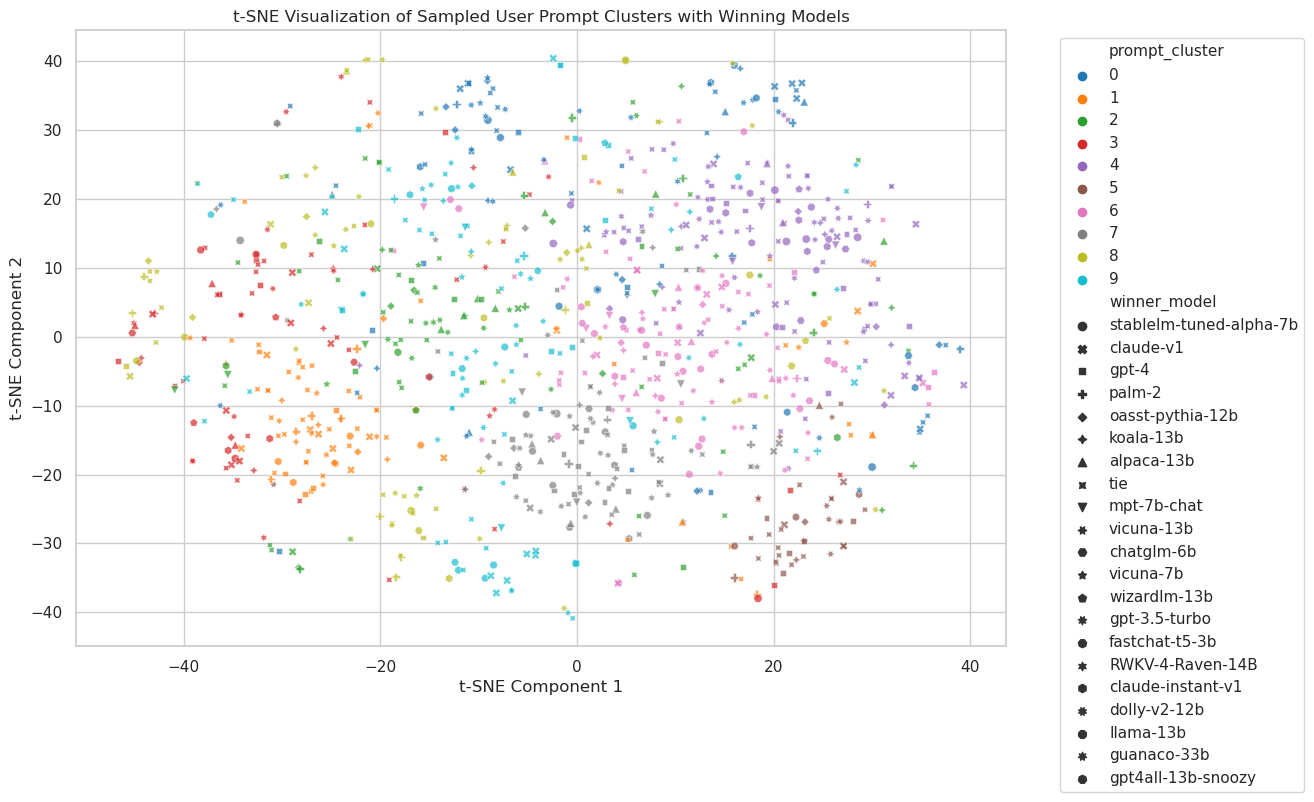

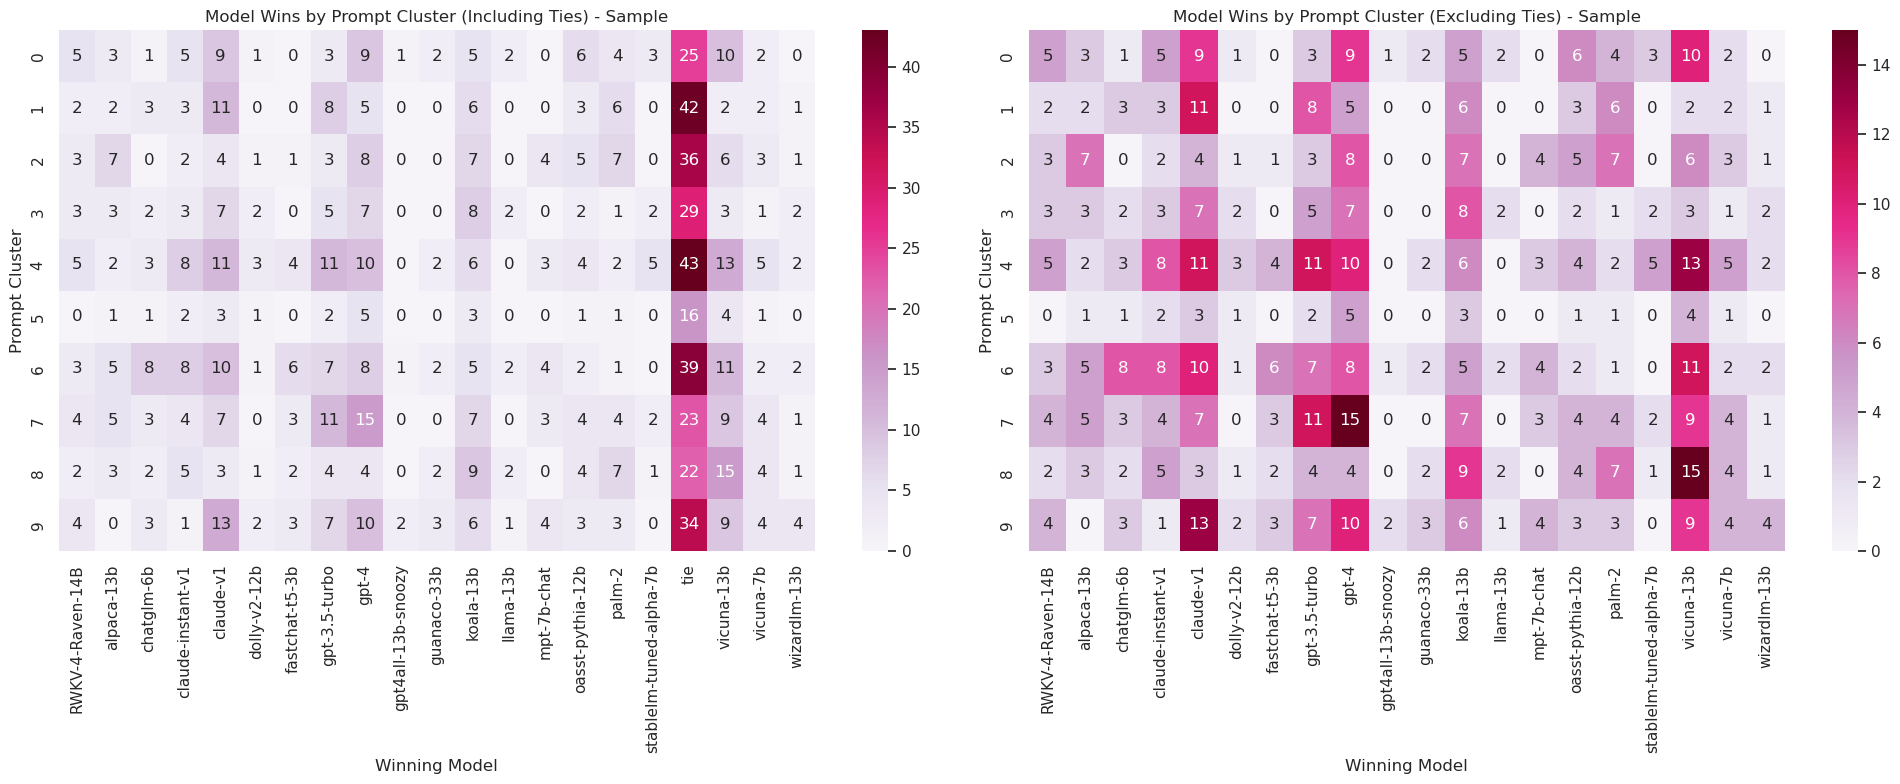

In [43]:
# Cluster the Prompt Embeddings Using KMeans on the Sample Data
n_clusters = 10  # number of clusters
sample_prompt_embeddings = np.vstack(sample_conversation['user_prompt_embedding'].values)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sample_conversation['prompt_cluster'] = kmeans.fit_predict(sample_prompt_embeddings)

# Run t-SNE on the Sample Data for Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
sample_prompt_embeddings_2d = tsne.fit_transform(sample_prompt_embeddings)

# Add t-SNE results to the DataFrame for plotting
sample_conversation['tsne_1'] = sample_prompt_embeddings_2d[:, 0]
sample_conversation['tsne_2'] = sample_prompt_embeddings_2d[:, 1]

# Plot the t-SNE Visualization with Clusters and Model Wins
plt.figure(figsize=(12, 8))
sns.scatterplot(data=sample_conversation, x='tsne_1', y='tsne_2', hue='prompt_cluster', style='winner_model', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Sampled User Prompt Clusters with Winning Models')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Generate Heatmaps for Model Wins per Cluster (With and Without Ties)

# Heatmap including ties
cluster_model_performance_with_tie_sample = sample_conversation.groupby(['prompt_cluster', 'winner_model']).size().unstack(fill_value=0)

# Heatmap excluding ties
sample_df_without_tie = sample_conversation[sample_conversation['winner_model'] != 'tie']
cluster_model_performance_without_tie_sample = sample_df_without_tie.groupby(['prompt_cluster', 'winner_model']).size().unstack(fill_value=0)

# Plot both heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1]})

# Heatmap with ties
sns.heatmap(cluster_model_performance_with_tie_sample, annot=True, cmap="PuRd", fmt="d", ax=axes[0])
axes[0].set_title("Model Wins by Prompt Cluster (Including Ties) - Sample")
axes[0].set_xlabel("Winning Model")
axes[0].set_ylabel("Prompt Cluster")

# Heatmap without ties
sns.heatmap(cluster_model_performance_without_tie_sample, annot=True, cmap="PuRd", fmt="d", ax=axes[1])
axes[1].set_title("Model Wins by Prompt Cluster (Excluding Ties) - Sample")
axes[1].set_xlabel("Winning Model")
axes[1].set_ylabel("Prompt Cluster")

plt.tight_layout()
plt.show()

**Top-5 Models Performance on Clusters of Similar Prompts**: In the above plots we see some patterns but it would be better to focus further on specific models and visualize their performance on the prompt clusters. This time we will also take 5 clusters instead of 10.

In [44]:
# We will take 200 rows per model
n_per_model = 200

# Perform stratified sampling with an equal count per model
sample_conversation = conversation[conversation['winner_model'].isin(top_five)].groupby('winner_model', group_keys=False).apply(lambda x: x.sample(n=n_per_model, random_state=42))

# Verify the distribution to ensure it’s balanced
print(sample_conversation['winner_model'].value_counts())

winner_model
claude-v1        200
gpt-3.5-turbo    200
gpt-4            200
koala-13b        200
vicuna-13b       200
Name: count, dtype: int64


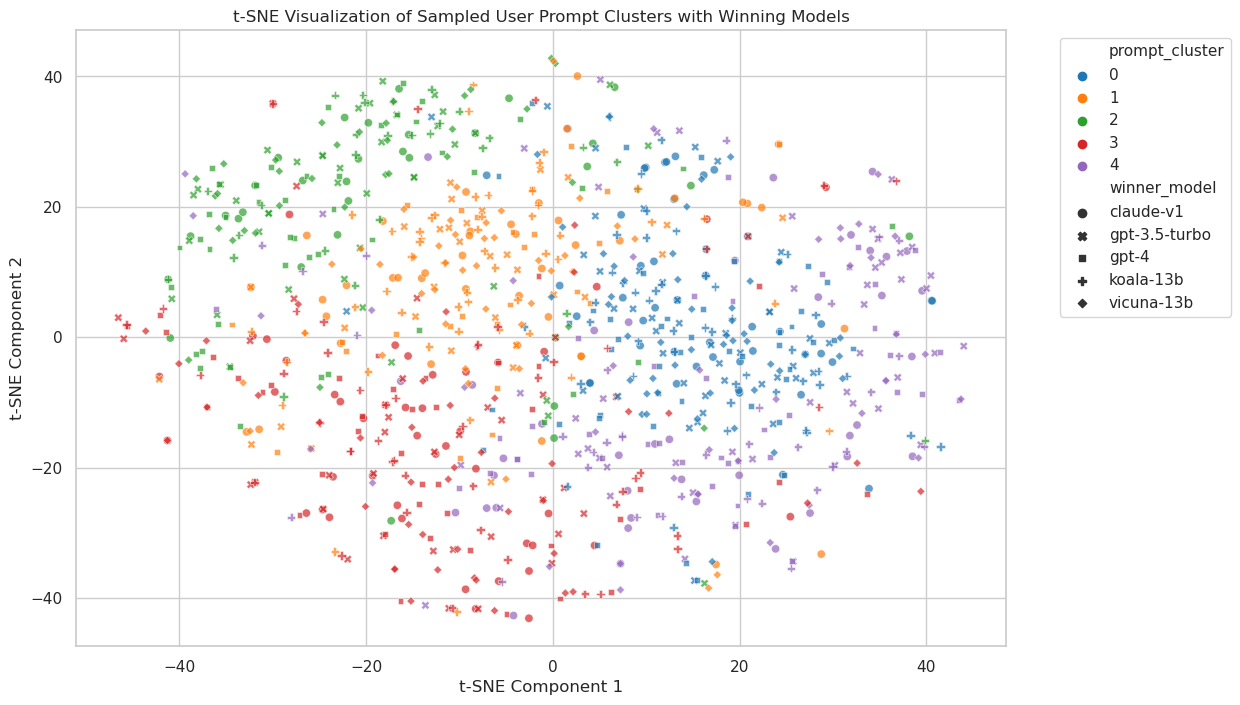

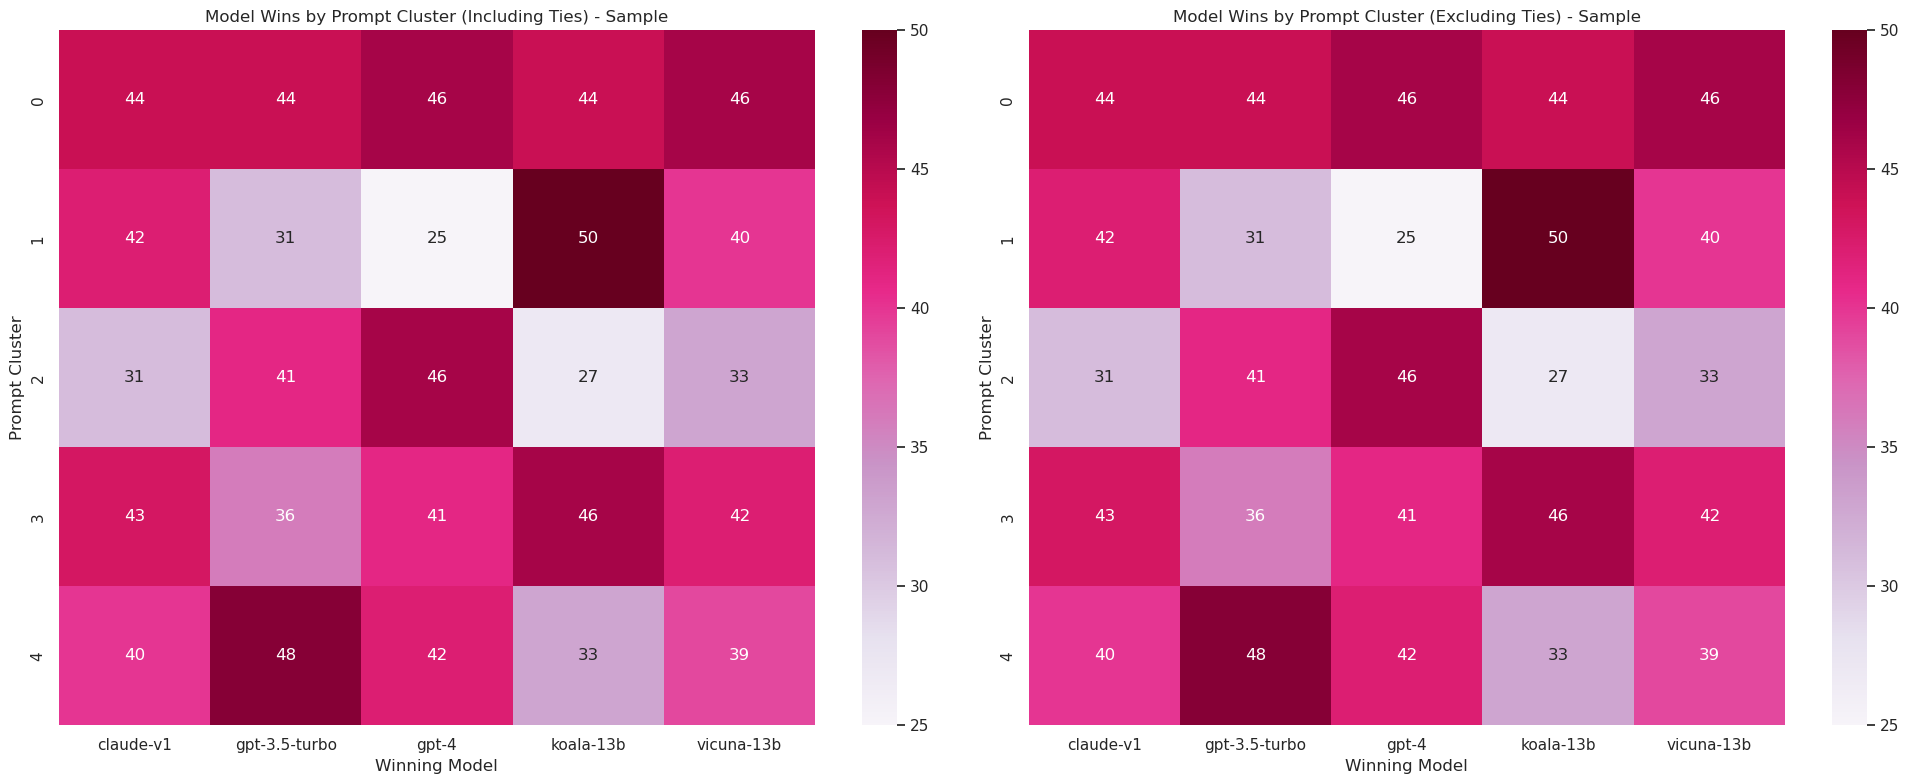

In [45]:
# Cluster the Prompt Embeddings Using KMeans on the Sample Data
n_clusters = 5  # number of clusters
sample_prompt_embeddings = np.vstack(sample_conversation['user_prompt_embedding'].values)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sample_conversation['prompt_cluster'] = kmeans.fit_predict(sample_prompt_embeddings)

# Run t-SNE on the Sample Data for Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
sample_prompt_embeddings_2d = tsne.fit_transform(sample_prompt_embeddings)

# Add t-SNE results to the DataFrame for plotting
sample_conversation['tsne_1'] = sample_prompt_embeddings_2d[:, 0]
sample_conversation['tsne_2'] = sample_prompt_embeddings_2d[:, 1]

# Plot the t-SNE Visualization with Clusters and Model Wins
plt.figure(figsize=(12, 8))
sns.scatterplot(data=sample_conversation, x='tsne_1', y='tsne_2', hue='prompt_cluster', style='winner_model', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Sampled User Prompt Clusters with Winning Models')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Generate Heatmaps for Model Wins per Cluster (With and Without Ties)

# Heatmap including ties
cluster_model_performance_with_tie_sample = sample_conversation.groupby(['prompt_cluster', 'winner_model']).size().unstack(fill_value=0)

# Heatmap excluding ties
sample_df_without_tie = sample_conversation[sample_conversation['winner_model'] != 'tie']
cluster_model_performance_without_tie_sample = sample_df_without_tie.groupby(['prompt_cluster', 'winner_model']).size().unstack(fill_value=0)

# Plot both heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1]})

# Heatmap with ties
sns.heatmap(cluster_model_performance_with_tie_sample, annot=True, cmap="PuRd", fmt="d", ax=axes[0])
axes[0].set_title("Model Wins by Prompt Cluster (Including Ties) - Sample")
axes[0].set_xlabel("Winning Model")
axes[0].set_ylabel("Prompt Cluster")

# Heatmap without ties
sns.heatmap(cluster_model_performance_without_tie_sample, annot=True, cmap="PuRd", fmt="d", ax=axes[1])
axes[1].set_title("Model Wins by Prompt Cluster (Excluding Ties) - Sample")
axes[1].set_xlabel("Winning Model")
axes[1].set_ylabel("Prompt Cluster")

plt.tight_layout()
plt.show()

**Takeaways**
- T-SNE Plot
    - The t-SNE plot shows five distinct clusters of prompt embeddings. The separations suggest that the prompt embeddings have enough semantic difference to form identifiable clusters.
    - The scatter plot symbols are distributed fairly evenly across clusters, suggesting that models win in various clusters rather than being confined to a single type of question. However, there are slight concentrations of certain models in specific clusters, hinting at possible areas where these models may perform better. For example, GPT-4 has a noticeable presence across clusters, with some denser regions in certain clusters, especially clusters 1 and 4.
    - Some clusters appear more densely packed with points (e.g., clusters 1 and 3), while others are more spread out. The denser clusters might contain more similar or thematically related prompts, while the sparser clusters might represent a broader diversity of question types within those clusters
    - The dispersion of each model across clusters suggests that most top models can generalize across a range of prompt types rather than being limited to a specific prompt category. This generalization is especially relevant for models like GPT-4, which has a presence in all clusters
- Heatmap
    - In Cluster 1, GPT-4 has a notably higher win count (50 wins), suggesting that it performs particularly well on prompts within this cluster, even when ties are excluded. Cluster 4 also shows a preference for GPT-4 with 48 wins, indicating that GPT-4 is strong in multiple clusters.
    - Claude-v1 has a balanced win count across clusters, showing moderate performance but no particular dominance in any specific cluster. GPT-3.5-turbo performs consistently well across clusters but doesn’t dominate any specific one, suggesting it’s more of a generalist.
    - Koala-13b and Vicuna-13b have lower win counts in most clusters, particularly in Cluster 1 and Cluster 4, where GPT-4 dominates. This indicates that these models may struggle with the prompt types represented in these clusters.
    - While we can’t directly infer prompt types from the embeddings, the cluster preferences suggest that certain models (especially GPT-4) are better suited for specific types of questions, likely reflected in Clusters 1 and 4.

**Top-5 Models Performance on Clusters of Similar Responses:** Next, we will focus on the response embeddings to see the performance of top-5 models on similar responses

In [46]:
# Stack response embeddings from both model_a and model_b responses for clustering
all_response_embeddings = np.vstack([
    np.vstack(sample_conversation['model_a_response_embedding'].values),
    np.vstack(sample_conversation['model_b_response_embedding'].values)
])

# Perform clustering (e.g., using 5 clusters)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
response_clusters = kmeans.fit_predict(all_response_embeddings)

# Assign clusters back to the original dataframe for each model's response
sample_conversation['model_a_response_cluster'] = response_clusters[:len(sample_conversation)]
sample_conversation['model_b_response_cluster'] = response_clusters[len(sample_conversation):]

# Assign the response cluster based on the winning model's response embedding cluster
sample_conversation['winning_response_cluster'] = np.where(
    sample_conversation['winner_model'] == sample_conversation['model_a'],
    sample_conversation['model_a_response_cluster'],
    sample_conversation['model_b_response_cluster']
)

# Group by response cluster of the winning model and the winning model itself
model_wins_by_cluster = sample_conversation.groupby(['winning_response_cluster', 'winner_model']).size().unstack(fill_value=0)

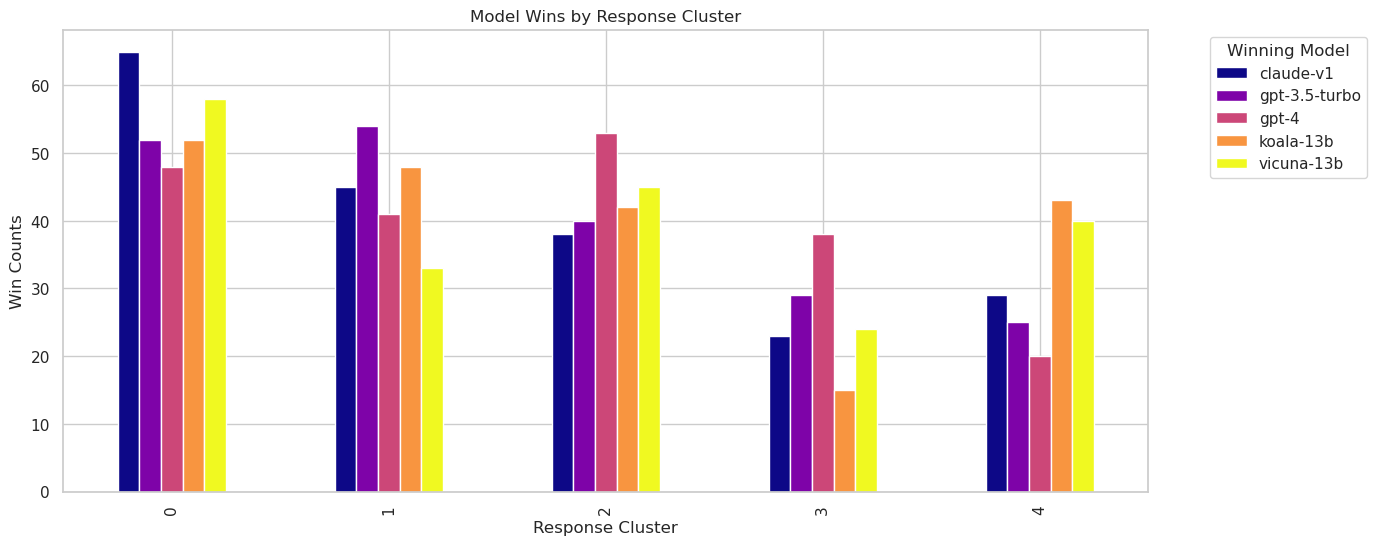

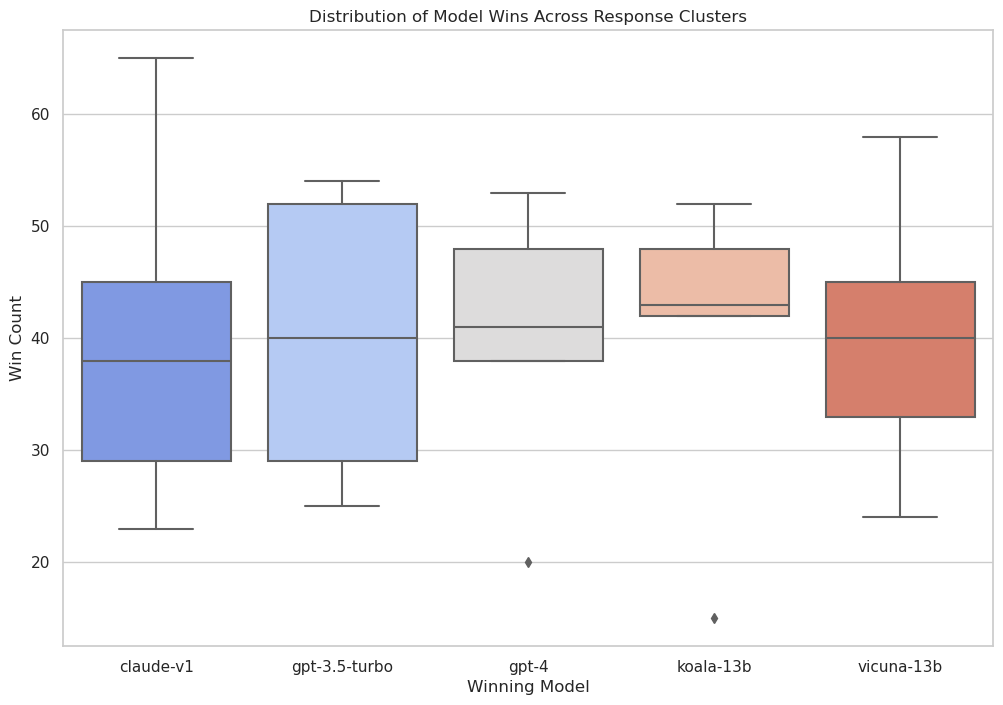

In [47]:
# Plot grouped bar chart
model_wins_by_cluster.plot(kind='bar', figsize=(14, 6), colormap='plasma')
plt.title("Model Wins by Response Cluster")
plt.xlabel("Response Cluster")
plt.ylabel("Win Counts")
plt.legend(title="Winning Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Convert the data for a dot plot
box_data = model_wins_by_cluster.reset_index().melt(id_vars="winning_response_cluster", var_name="Winning Model", value_name="Win Count")

# Plot box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(data=box_data, x="Winning Model", y="Win Count", palette="coolwarm")
plt.title("Distribution of Model Wins Across Response Clusters")
plt.xlabel("Winning Model")
plt.ylabel("Win Count")
plt.show()

**Takeaways**

- Grouped Bar Chart: GPT-4 and GPT-3.5-turbo maintain relatively high win counts across multiple clusters, suggesting that users tend to favor these models consistently, regardless of the specific response cluster. Vicuna-13b shows variability, with particularly high counts in certain clusters (like clusters 0 and 4). This may indicate that Vicuna-13b excels at specific types of questions or response styles, making it more likely to be chosen within these clusters.
- Box Plot: GPT-4 has a narrow interquartile range and fewer extreme values, indicating stable performance across response clusters. This implies that users consistently choose GPT-4 regardless of the response cluster, pointing to a general preference for this model. GPT-3.5-turbo shows a broader range of win counts, indicating it performs well across most clusters but has more variability than GPT-4. Claude-v1 and Koala-13b show more spread and lower median win counts, indicating they are less likely to be chosen consistently across clusters. This suggests these models may perform better in specific clusters but are less preferred in general.
- Cluster-Specific Strengths for Certain Models: Vicuna-13b has a wider range, suggesting it might perform well in particular clusters but is less consistent across all clusters. The variation in counts for Claude-v1 and Koala-13b across clusters indicates that these models may be chosen only under certain conditions or response types, supporting the idea that some models are better suited for specific response clusters.

### Key Observations and Takeaways from Embeddings Dataset

- **Looking at prompt embeddings, can we say that some models are better at certain clusters of questions?**
Yes, prompt embeddings do suggest that certain models stand out in specific question clusters. For example, GPT-4 shows strong performance in Clusters 1 and 4, hinting that it might be better suited for certain types of prompts or topics compared to other models. Similarly, GPT-3.5-Turbo did well in Clusters 0 and 4, and Koala-13B performed strongly in Clusters 1 and 3. Claude-V1 performed poorly in Cluster 2.

- **Looking at response embeddings, is a user more likely to pick the same model in the same cluster of responses?**
Yes, users tend to favor particular models within specific response clusters. GPT-4, for instance, is consistently the go-to choice across clusters, which suggests it’s generally reliable or appealing in its responses. Other models, like Vicuna-13b, seem to do well in only a few clusters such as Cluster 0. In cluster 1 GPT-3.5-Turbo performed the strongest, whereas Koala-13B was the strongest in Cluster 4.

- **Which prompt clusters tend to have higher tie ratios across models?**
Some clusters have a higher number of ties, which might mean these questions are more ambiguous or open-ended, making it hard for any model to stand out.

## Auxilliary Data Set - Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks. For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

In [48]:
# View the data
topic_and_hardness.head(5)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9,"Emotions, Relationships",This prompt involves understanding complex hum...,8,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2,Comparative Analysis,This prompt assesses the AI's ability to analy...,6,Photography comparison,This prompt is subjective and does not provide...,2
3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Chatbot Arena,This prompt requires problem-solving skills an...,8,Chatbot Arena,This prompt requires the AI to engage in probl...,8,Chatbot Arena,This prompt requires problem-solving skills an...,8
4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Time Query,This prompt is very straightforward and does n...,2,Date Inquiry,This prompt is very straightforward and does n...,2,Time-based Inquiry,This prompt is too straightforward and simply ...,2


Check the **data types**.

In [49]:
topic_and_hardness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   question_id                       25282 non-null  object
 1   prompt                            25282 non-null  object
 2   openai_scores_raw_choices_nested  25282 non-null  object
 3   topic_modeling_1                  25256 non-null  object
 4   score_reason_1                    25256 non-null  object
 5   score_value_1                     25256 non-null  object
 6   topic_modeling_2                  25256 non-null  object
 7   score_reason_2                    25256 non-null  object
 8   score_value_2                     25256 non-null  object
 9   topic_modeling_3                  25256 non-null  object
 10  score_reason_3                    25256 non-null  object
 11  score_value_3                     25256 non-null  object
dtypes: object(12)
memo

Check for **null values** in the data.

In [50]:
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    26
score_reason_1                      26
score_value_1                       26
topic_modeling_2                    26
score_reason_2                      26
score_value_2                       26
topic_modeling_3                    26
score_reason_3                      26
score_value_3                       26
dtype: int64

### Cleaning

**Granularity**: the data is on the question-level.

From the above analysis we can see that there is **missing data in our dataframe**. 

By observing the `openai_scores_raw_choices_nested` variable we can see that it is not missing any data. This variable contains the nested topic_modelling, score_reason, and score_value variables. It is possible that there was an error in the previous attempt in flattening this array. Similar to the flattening we performed above for the main dataset, we can attempt to re-flatten this variable to see if the values are actually missing.

In [51]:
topic_and_hardness["openai_scores_raw_choices_nested"].iloc[0]

[{'finish_reason': 'stop',
  'index': 0,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Technical Comparison",\n    "score_reason": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI\'s factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",\n    "score_value": 9\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 1,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Software Comparison",\n    "score_reason": "This prompt assesses the AI\'s factual accuracy in distinguishing between two similar but distinct software frameworks.",\n    "score_value": 8\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 2,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeli

Obtain the content similar to the Main data set above.

In [52]:
ind_1 = topic_and_hardness["openai_scores_raw_choices_nested"].str[0].str["message"].str["content"]
ind_1

0        {\n    "topic_modeling": "Technical Comparison...
1        {\n    "topic_modeling": "Reasoning, Emotion",...
2        {\n    "topic_modeling": "Camera comparison",\...
3        {\n    "topic_modeling": "Chatbot Arena",\n   ...
4        {\n    "topic_modeling": "Time Query",\n    "s...
                               ...                        
25277    {\n    "topic_modeling": "Mathematics, Measure...
25278    {\n    "topic_modeling": "Information Retrieva...
25279    {\n    "topic_modeling": "Training, Hyperparam...
25280    {\n    "topic_modeling": "Language Modeling",\...
25281    {\n    "topic_modeling": "Workflow Automation"...
Name: openai_scores_raw_choices_nested, Length: 25282, dtype: object

Observe that the above data is dtype object. It is specifically an unparsed JSON object. So let's attempt to parse it.

In [53]:
import json

# Create a function to parse the valid rows
def parse_valid(row):
    try:
        # Try to parse a row
        return json.loads(row)
    except (json.JSONDecodeError):
        # Return None if the row cannot be parsed
        return None

# Apply the function to parse the content
index_1 = topic_and_hardness["openai_scores_raw_choices_nested"].str[0].str["message"].str["content"].apply(parse_valid)
index_1

0        {'topic_modeling': 'Technical Comparison', 'sc...
1        {'topic_modeling': 'Reasoning, Emotion', 'scor...
2        {'topic_modeling': 'Camera comparison', 'score...
3        {'topic_modeling': 'Chatbot Arena', 'score_rea...
4        {'topic_modeling': 'Time Query', 'score_reason...
                               ...                        
25277    {'topic_modeling': 'Mathematics, Measurement',...
25278    {'topic_modeling': 'Information Retrieval', 's...
25279    {'topic_modeling': 'Training, Hyperparameters'...
25280    {'topic_modeling': 'Language Modeling', 'score...
25281    {'topic_modeling': 'Workflow Automation', 'sco...
Name: openai_scores_raw_choices_nested, Length: 25282, dtype: object

Check which rows contain **invalid data**.

In [54]:
index_1[index_1.isnull() == True]

584     None
5595    None
Name: openai_scores_raw_choices_nested, dtype: object

Let's create a variable to store these row values. We will use our parse_valid function for index_2 and index_3 and append any rows which do not contain valid information.

In [55]:
invalid_rows = []
invalid_rows.extend(list(index_1[index_1.isnull() == True].index))

# Obtain index_2 and index_3
index_2 = topic_and_hardness["openai_scores_raw_choices_nested"].str[1].str["message"].str["content"].apply(parse_valid)
index_3 = topic_and_hardness["openai_scores_raw_choices_nested"].str[2].str["message"].str["content"].apply(parse_valid)

# Append invalid rows to the list
invalid_rows.extend(list(index_2[index_2.isnull() == True].index))
invalid_rows.extend(list(index_3[index_3.isnull() == True].index))

# Make it a set to only contain unique values
invalid_rows = set(invalid_rows)

# Check the invalid rows
invalid_rows

{584, 5595}

Now that we have parsed as much information as possible out of the nested variable. Let's update the topic_and_hardness dataframe with the new values.

In [56]:
# Update the values from index_1
topic_and_hardness["topic_modeling_1"] = index_1.str["topic_modeling"]
topic_and_hardness["score_reason_1"] = index_1.str["score_reason"]
topic_and_hardness["score_value_1"] = index_1.str["score_value"]

# Update the values from index_2
topic_and_hardness["topic_modeling_2"] = index_3.str["topic_modeling"]
topic_and_hardness["score_reason_2"] = index_3.str["score_reason"]
topic_and_hardness["score_value_2"] = index_3.str["score_value"]

# Update the values from index_2
topic_and_hardness["topic_modeling_3"] = index_3.str["topic_modeling"]
topic_and_hardness["score_reason_3"] = index_3.str["score_reason"]
topic_and_hardness["score_value_3"] = index_3.str["score_value"]

Check for null values now in the data.

In [57]:
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    22
score_reason_1                      21
score_value_1                       21
topic_modeling_2                    25
score_reason_2                      25
score_value_2                       25
topic_modeling_3                    25
score_reason_3                      25
score_value_3                       25
dtype: int64

We have reduced the number of null values in the data, but there is still remaining null values in the nested data. Let's explore this in more detail.

Filter the data to view null values

In [58]:
remaining_invalid_data = topic_and_hardness[topic_and_hardness["topic_modeling_3"].isnull() == True]
display(len(remaining_invalid_data))
display(remaining_invalid_data.head())

25

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
584,e6d45ead33114cca8ee3cfa028517eff,I want you to act as a linux terminal. I will ...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
5060,addaa796ee094f029f8014ea1468df8a,\nAssume the role of an API that provides a ch...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,The task involves understanding data dimension...,9,None,None,None,None,None,None
5458,d37eb99864fa41ecab49026abdddb53e,I want you to act as a javascript console. I w...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
5595,6da02001e74041d0947982fb4d05db9e,I want you to act as a linux terminal. I will ...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
6260,d93e36df73e84aa2ade15d4a038c098f,# User Input\n## This is what the user request...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None


**Removing Remaining Invalid Data**

You can see from the above dataframe that these rows have no meaningful data for topic_modeling, score_reason, or score_value. There are some cases where the first index has meaningful data. However, given the size of the dataset there is not reason to attempt to impute the missing values. Imputing the missing data as an average for the model would skew the results, and since we are only removing a vert small portion of the data, the effect of removing them will be insignificant.

Let's clean up our dataframe by removing the `openai_scores_raw_choices_nested` column, now that it is no longer needed, and removing the rows containing the missing values. 

In [59]:
topic_and_hardness = topic_and_hardness.drop(list(topic_and_hardness[topic_and_hardness["topic_modeling_3"].isnull() == True].index))
topic_and_hardness = topic_and_hardness.drop(columns = "openai_scores_raw_choices_nested")

Now check for null values

In [60]:
topic_and_hardness.isnull().sum()

question_id         0
prompt              0
topic_modeling_1    0
score_reason_1      0
score_value_1       0
topic_modeling_2    0
score_reason_2      0
score_value_2       0
topic_modeling_3    0
score_reason_3      0
score_value_3       0
dtype: int64

**There are no null values anymore**

**Hardness Score**

Now that we have solved the issue with null values, lets evaluate whether the parsed data has inconsistent formatting. Specifically, the data we are concerned about for analysis is the hardness score. So let us determine if the hardness score has inconsistent formatting.

In [61]:
topic_and_hardness["score_value_1"][
    topic_and_hardness["score_value_1"].apply(lambda x: isinstance(x, list))
]

12       [[8]]
48       [[7]]
86       [[7]]
144      [[8]]
181      [[7]]
         ...  
25157    [[7]]
25170    [[7]]
25184    [[8]]
25223    [[7]]
25240    [[8]]
Name: score_value_1, Length: 469, dtype: object

Let's convert these list of lists to ints.

In [62]:
# Convert the list into an int
topic_and_hardness["score_value_1"] = topic_and_hardness["score_value_1"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

Repeat this for score_value_2 and score_value_3

In [63]:
topic_and_hardness["score_value_2"] = topic_and_hardness["score_value_2"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

# Convert the list into an int
topic_and_hardness["score_value_3"] = topic_and_hardness["score_value_3"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

**Topic Modelling**

Score value contained nested values because when it was written into the JSON file it was written as a nested list.  Now we need to check the rest of our data for incorrect formatting. Let's check the topic_modeling data next.

In [64]:
# Check topic modeling 1
topic_and_hardness["topic_modeling_1"][
    topic_and_hardness["topic_modeling_1"].apply(lambda x: isinstance(x, list))
]

8632             [astronomy, planets]
16412              [Combat, Conflict]
22905    [videogames, recommendation]
Name: topic_modeling_1, dtype: object

Since these are only 3 cases, we can take the first element of each list.

In [65]:
# Take the first value from the list
topic_and_hardness["topic_modeling_1"] = topic_and_hardness["topic_modeling_1"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
    )

Repeat this for topic_modeling_1 and topic_modeling_2

In [66]:
topic_and_hardness["topic_modeling_2"] = topic_and_hardness["topic_modeling_2"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
)

topic_and_hardness["topic_modeling_3"] = topic_and_hardness["topic_modeling_3"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
)

**Score Reason**

Next, let's check the score reason variables.

In [67]:
display(topic_and_hardness["score_reason_1"][
    topic_and_hardness["score_reason_1"].apply(lambda x: isinstance(x, list))
])

# Check score response 2
display(topic_and_hardness["score_reason_2"][
    topic_and_hardness["score_reason_2"].apply(lambda x: isinstance(x, list))
])

display(topic_and_hardness["score_reason_3"][
    topic_and_hardness["score_reason_3"].apply(lambda x: isinstance(x, list))
])

Series([], Name: score_reason_1, dtype: object)

Series([], Name: score_reason_2, dtype: object)

Series([], Name: score_reason_3, dtype: object)

Score reason looks clean. It should be noted that the above analysis only checked the columns for lists. It did not check for any other data types. 

### Topic Modelling and Hardness Score Data Analysis

First, let's merge the main conversation dataset with the cleaned hardness dataset.

In [69]:
conversation_and_topic_hardness = conversation.merge(topic_and_hardness, left_on = "question_id", right_on = "question_id").drop(columns = [
    "conversation_a", "conversation_b"
])
display(conversation_and_topic_hardness.head())
display(conversation_and_topic_hardness.tail())

,question_id,model_a,model_b,winner,judge,winner_model,user_prompt,user_prompt_length,model_a_response,model_a_response_length,...,prompt,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,koala-13b,What is the difference between OpenCL and CUDA?,47,OpenCL and CUDA are two different programming ...,892,...,What is the difference between OpenCL and CUDA?,Technical Comparison,This prompt requires the AI to accurately comp...,9.0,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9.0,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9.0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,tie,Why did my parent not invite me to their wedding?,49,It is possible that your parent did not invite...,660,...,Why did my parent not invite me to their wedding?,"Reasoning, Emotion",This prompt requires the AI to understand huma...,9.0,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8.0,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8.0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,oasst-pythia-12b,"Fuji vs. Nikon, which is better?",32,Both Fuji and Nikon are popular camera brands ...,1114,...,"Fuji vs. Nikon, which is better?",Camera comparison,This prompt does not require problem-solving s...,2.0,Photography comparison,This prompt is subjective and does not provide...,2.0,Photography comparison,This prompt is subjective and does not provide...,2.0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,oasst-pythia-12b,How to build an arena for chatbots?,35,Building an arena for chatbots can be done by ...,1575,...,How to build an arena for chatbots?,Chatbot Arena,This prompt requires problem-solving skills an...,8.0,Chatbot Arena,This prompt requires problem-solving skills an...,8.0,Chatbot Arena,This prompt requires problem-solving skills an...,8.0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,vicuna-13b,When is it today?,17,"I'm sorry, I cannot determine the current date...",267,...,When is it today?,Time Query,This prompt is very straightforward and does n...,2.0,Time-based Inquiry,This prompt is too straightforward and simply ...,2.0,Time-based Inquiry,This prompt is too straightforward and simply ...,2.0


,question_id,model_a,model_b,winner,judge,winner_model,user_prompt,user_prompt_length,model_a_response,model_a_response_length,...,prompt,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
25272,fb4d58ef8649472783d364a9c1c8239e,palm-2,chatglm-6b,model_a,arena_user_21398,palm-2,If a tap is outputting 2500 ml a minute. How m...,102,"A litre is equal to 1000 ml, so 50 litres is e...",143,...,If a tap is outputting 2500 ml a minute. How m...,"Mathematics, Measurement",This prompt assesses the AI's ability in conve...,7.0,"Mathematics, Problem-solving","This prompt requires converting units, perform...",8.0,"Mathematics, Problem-solving","This prompt requires converting units, perform...",8.0
25273,8777c4945d85469d96cd26fc2ea6f64a,alpaca-13b,claude-instant-v1,tie,arena_user_21246,tie,who is the president of the U.S.A?,34,Joe Biden is currently the President of the Un...,115,...,who is the president of the U.S.A?,Information Retrieval,This prompt is a straightforward factual quest...,2.0,Factual knowledge,This prompt simply tests basic factual knowled...,2.0,Factual knowledge,This prompt simply tests basic factual knowled...,2.0
25274,86063a921be548989c55b85497ab009a,claude-instant-v1,guanaco-33b,model_a,arena_user_20785,claude-instant-v1,how to train lora for stable diffusion? explai...,114,Training Stable Diffusion models like LoRA req...,2015,...,how to train lora for stable diffusion? explai...,"Training, Hyperparameters",This prompt requires the AI to demonstrate pro...,8.0,Machine Learning,This prompt requires the AI to demonstrate pro...,7.0,Machine Learning,This prompt requires the AI to demonstrate pro...,7.0
25275,f72930b382e949ea879e7abf3cb1e587,guanaco-33b,koala-13b,model_a,arena_user_21328,guanaco-33b,how to evaluate a language model output?,40,Evaluating a language model output involves se...,1980,...,how to evaluate a language model output?,Language Modeling,This prompt primarily assesses the AI's profic...,7.0,Language modeling,This prompt focuses on evaluating a language m...,8.0,Language modeling,This prompt focuses on evaluating a language m...,8.0
25276,a147958b2bd049229facdbffa72a4662,chatglm-6b,wizardlm-13b,tie,arena_user_21247,tie,generate a detailed description on how to use ...,134,Power Automate is a powerful tool that allows ...,1533,...,generate a detailed description on how to use ...,Workflow Automation,This prompt requires the AI to demonstrate kno...,9.0,Workflow Automation,This task requires problem-solving skills and ...,8.0,Workflow Automation,This task requires problem-solving skills and ...,8.0


Next, calculate the average score and assign it to a new column.

In [70]:
conversation_and_topic_hardness["avg_score"] = (conversation_and_topic_hardness["score_value_1"] + conversation_and_topic_hardness["score_value_2"] + conversation_and_topic_hardness["score_value_3"]) / 3

From here onwards, we will focus only on the rows where there was no tie.

In [71]:
conversation_and_topic_hardness_win = conversation_and_topic_hardness[conversation_and_topic_hardness["winner"].isin(["model_a", "model_b"])].copy()

Now we will bin the hardness score into 5 categories: Very Easy, Easy, Medium, Hard, Very Hard

In [72]:
bins = [0, 2, 4, 6, 8, 10]
labels = ['Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard']

conversation_and_topic_hardness_win["hardness_cat"] = pd.cut(conversation_and_topic_hardness_win["avg_score"], bins=bins, labels=labels)

**Wins In Each Hardness Category**

Count the wins for each model in each hardness category

In [73]:
win_count = conversation_and_topic_hardness_win.groupby(["winner_model", "hardness_cat"]).size().reset_index(name = "win_count")
win_count

,winner_model,hardness_cat,win_count
0,RWKV-4-Raven-14B,Very Easy,48
1,RWKV-4-Raven-14B,Easy,23
2,RWKV-4-Raven-14B,Medium,33
3,RWKV-4-Raven-14B,Hard,411
4,RWKV-4-Raven-14B,Very Hard,138
...,...,...,...
95,wizardlm-13b,Very Easy,18
96,wizardlm-13b,Easy,7
97,wizardlm-13b,Medium,18
98,wizardlm-13b,Hard,216


In [74]:
# Concatenate match counts for model_a and model_b into a single DataFrame
model_a_match_count = conversation_and_topic_hardness_win.groupby(["model_a", "hardness_cat"]).size().reset_index(name="match_count")
model_b_match_count = conversation_and_topic_hardness_win.groupby(["model_b", "hardness_cat"]).size().reset_index(name="match_count")

# Rename columns for consistency
model_a_match_count.rename(columns={"model_a": "model"}, inplace=True)
model_b_match_count.rename(columns={"model_b": "model"}, inplace=True)

# Concatenate match counts for both model_a and model_b
total_match_count = pd.concat([model_a_match_count, model_b_match_count])

# Aggregate total match counts by model and hardness category
total_match_count = total_match_count.groupby(["model", "hardness_cat"]).sum().reset_index()

# Merge the total match counts with the win counts on 'winner_model' and 'hardness_cat'
df_win_tot = pd.merge(win_count, total_match_count, 
                      left_on=["winner_model", "hardness_cat"], 
                      right_on=["model", "hardness_cat"], 
                      how="inner")

# Compute the win ratio for each model in each hardness category
df_win_tot["win_ratio"] = df_win_tot["win_count"] / df_win_tot["match_count"]

# Drop the redundant 'model' column from the final DataFrame
df_win_tot = df_win_tot.drop(columns=["model"])

# Display the result
print(df_win_tot)

        winner_model hardness_cat  win_count  match_count  win_ratio
0   RWKV-4-Raven-14B    Very Easy         48           96   0.500000
1   RWKV-4-Raven-14B         Easy         23           74   0.310811
2   RWKV-4-Raven-14B       Medium         33          103   0.320388
3   RWKV-4-Raven-14B         Hard        411         1257   0.326969
4   RWKV-4-Raven-14B    Very Hard        138          396   0.348485
..               ...          ...        ...          ...        ...
95      wizardlm-13b    Very Easy         18           35   0.514286
96      wizardlm-13b         Easy          7           18   0.388889
97      wizardlm-13b       Medium         18           34   0.529412
98      wizardlm-13b         Hard        216          386   0.559585
99      wizardlm-13b    Very Hard         48           98   0.489796

[100 rows x 5 columns]


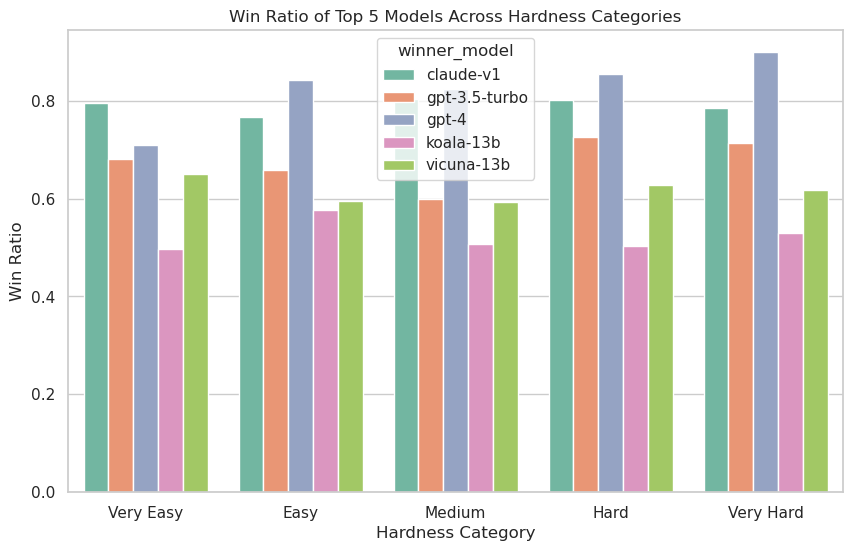

In [75]:
# Plot the results for the top five models
df_cat_top_five = df_win_tot[df_win_tot["winner_model"].isin(top_five)]

# Plot the win ratio for the top five models
plt.figure(figsize=(10, 6))
sns.barplot(data = df_cat_top_five, x='hardness_cat', y='win_ratio', hue='winner_model', palette='Set2')

# Add labels and title
plt.title('Win Ratio of Top 5 Models Across Hardness Categories')
plt.xlabel('Hardness Category')
plt.ylabel('Win Ratio')
plt.show();

**Takeaways**

- **How does the hardness score compare with the results from the top five models from the main data set?**
    - The above plot of "Win Ratio of Top 5 Models Across Hardness Categories" shows the correlation between the number of times a model won a competition based on the average hardness score. The hardness categories are bins that represent the average hardness score from the 'topic_and_hardness' dataframe. The bins are structured to contain ranges of values, for example, "Very Easy" is zero to two, "Easy" two to four, and so on. 
    - From the above plot of we can see that 'gpt-4' outperformed all other models for every category of hardness, except for "Very Easy" questions, where 'claude-v1' was the highest performing model. Interestingly, these results would infer that the order of the top five models would be different than that obtained solely based on win count. The plot shows that 'claude-v1' consistently performed better than 'vicuna-13b' even though 'vicuna-13b' took second in rankings based on win count, and 'claude-v1' was fourth. 
    - Based on this plot, I would maintain 'gpt-4' as the best performing model, but I would switch the order of 'claude-v1' and 'vicuna-13b' due to the reason discussed above. The rest of the ordering remains the same.
- **What are the most common topics?**
    - By taking the value counts of the "topic_modeling" data we can obtain a list of the most common topics in descending order. The top three topics based on this output are: creative writing, factual accuracy, and problem-solving/creativity. Creative writing is the most common with about 600 instances of the topic, which is almost 100 more instances than factual accuracy, and about 200 more instances than problem-solving/creativity. 
- **What is the hardness score of the most common topics.**
    - Based on the above dataframe of topics grouped by the mean of the average hardness score, for the top three topics mentioned above the average hardness score is: 8.2, 7.8, and 6.9 respectively.



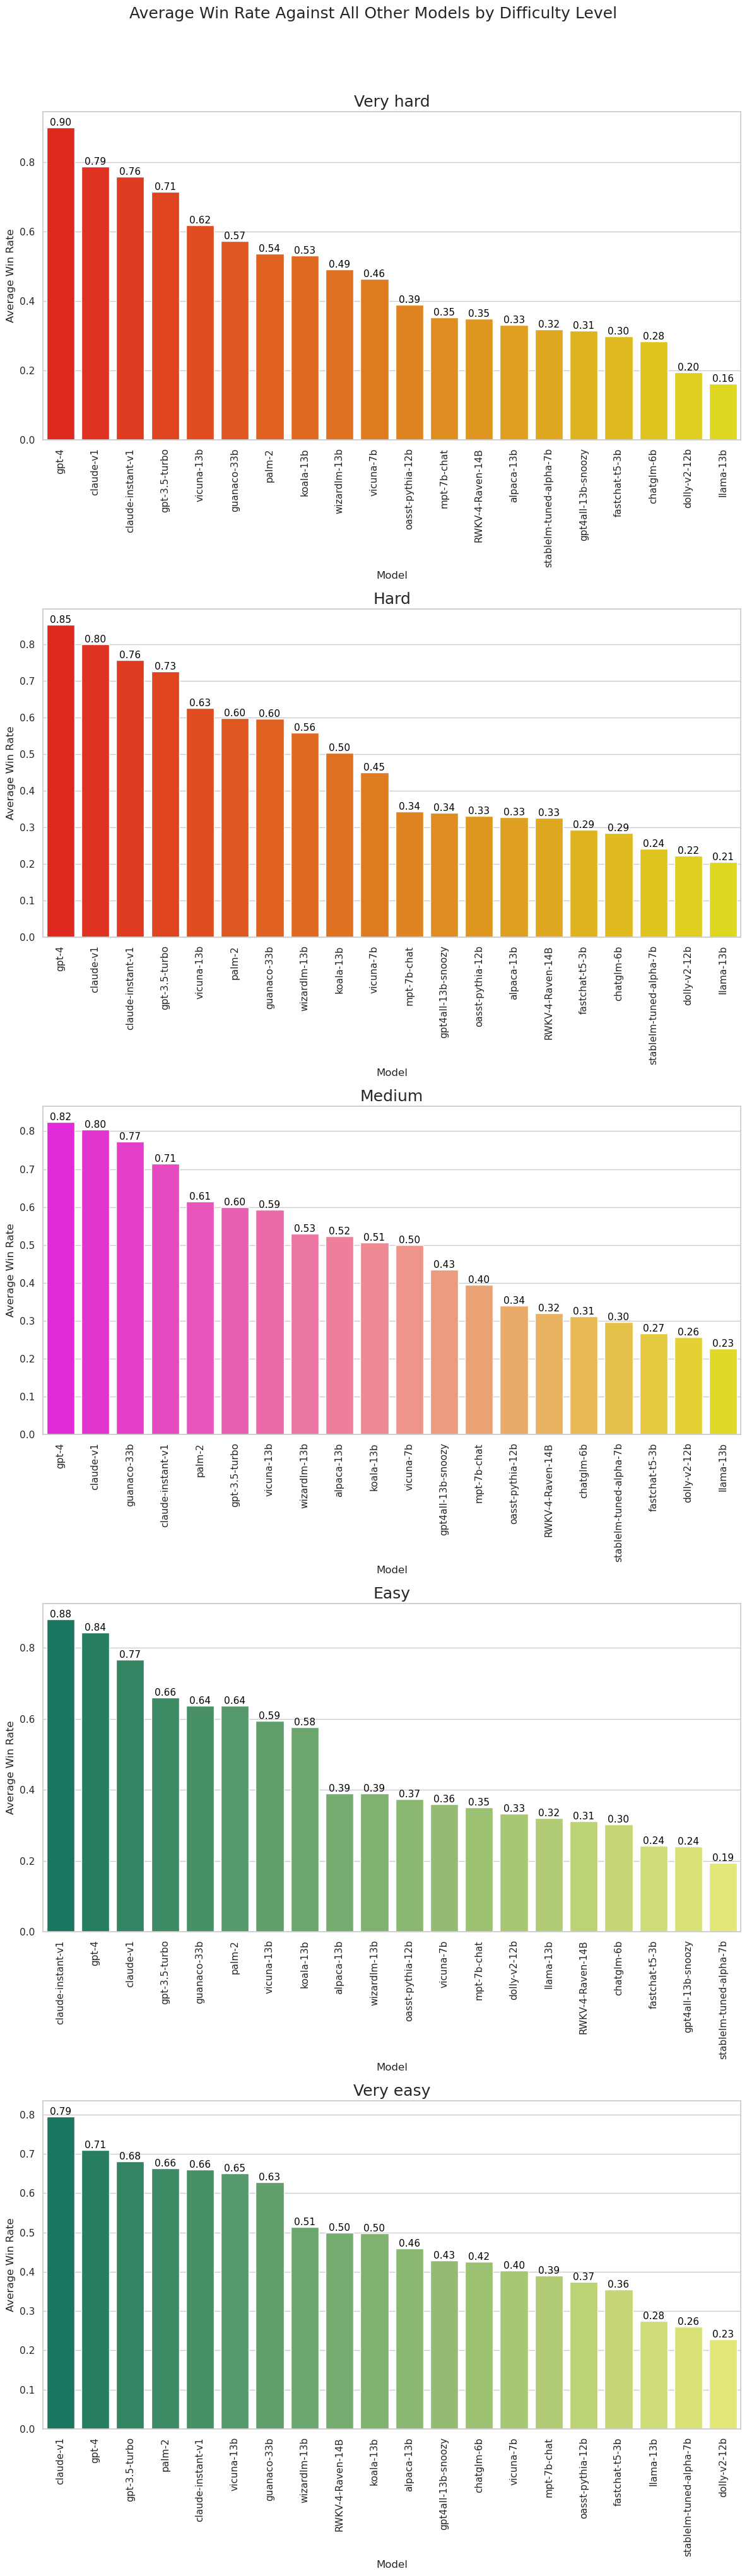

In [76]:
win_counts = conversation_and_topic_hardness_win.groupby(['hardness_cat', 'winner_model']).size().unstack(fill_value=0)

# Calculate the total matches for each model within each hardness category
model_a_counts = conversation_and_topic_hardness_win.groupby(['hardness_cat', 'model_a']).size().unstack(fill_value=0)
model_b_counts = conversation_and_topic_hardness_win.groupby(['hardness_cat', 'model_b']).size().unstack(fill_value=0)
total_matches = model_a_counts.add(model_b_counts, fill_value=0)

# Calculate win rate by dividing win counts by total matches for each model
average_win_rate = (win_counts / total_matches).fillna(0)

# Reshape the DataFrame for easier plotting
average_win_rate_long = average_win_rate.reset_index().melt(id_vars="hardness_cat", var_name="Model", value_name="Average Win Rate")

# Plot the average win rate for each model within each hardness category
# Define color maps for each hardness level
color_maps = {
    "Very Hard": "autumn",
    "Hard": "autumn",
    "Medium": "spring",
    "Easy": "summer",
    "Very Easy": "summer", 
}

# Set up the figure
fig, axes = plt.subplots(nrows=len(color_maps), ncols=1, figsize=(12, 8 * len(color_maps)))
fig.suptitle("Average Win Rate Against All Other Models by Difficulty Level", fontsize=18, y=1.02)

# Plot each hardness category separately
for ax, (hardness, cmap) in zip(axes, color_maps.items()):
    # Filter data for the current hardness level
    subset_data = average_win_rate_long[average_win_rate_long['hardness_cat'] == hardness]
    
    # Sort models by win rate for cleaner presentation
    subset_data = subset_data.sort_values(by="Average Win Rate", ascending=False)
    
    # Plot the bar chart with a color gradient
    bars = sns.barplot(data=subset_data, x="Model", y="Average Win Rate", ax=ax, palette=sns.color_palette(cmap, len(subset_data)))
    bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
    ax.set_title(f"{hardness.capitalize()}", fontsize=18)
    ax.set_xlabel("Model")  # Ensure xlabel appears under each plot
    
    # Add labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=11, color="black")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

**Takeaways**

- **Model Performance by Hardness Level**
   - Very Hard: GPT-4 leads with a high win rate, followed by Claude-v1 and Claude-instant-v1.
   - Hard: GPT-4 again ranks highest, maintaining strong performance, but the win rate gap between models narrows slightly compared to the "very hard" category.
   - Medium: GPT-4, Claude-v1, and Gemini-3B still rank at the top, but there’s a more balanced distribution across models, indicating slightly more competition on moderately difficult prompts.
   - Easy: GPT-4 and Claude-instant-v1 continue to perform well, but models like Gemini-3B and others gain more ground. This suggests that on easier questions, the performance difference among top models becomes less pronounced.
   - Very Easy: Here, the performance is even more leveled. While Claude-v1 and GPT-4 still perform well, other models achieve closer win rates, showing that on very easy tasks, the difference in quality among models is less noticeable.
- **Consistency Across Hardness Levels**
   - GPT-4 and Claude-v1 are consistently among the top performers across all levels of hardness. This implies these models have strong generalization capabilities, handling both difficult and easy questions effectively.
   - Models like GPT-3.5-turbo and Gemini-3B perform well but are more variable, excelling primarily in easier or medium categories compared to very hard questions.
- **Specialized vs. Generalized Strengths**
   - Some models show strengths only at specific difficulty levels. For instance, certain models that perform decently on "medium" or "easy" questions drop significantly in win rate as the difficulty increases, indicating a specialization in simpler tasks.

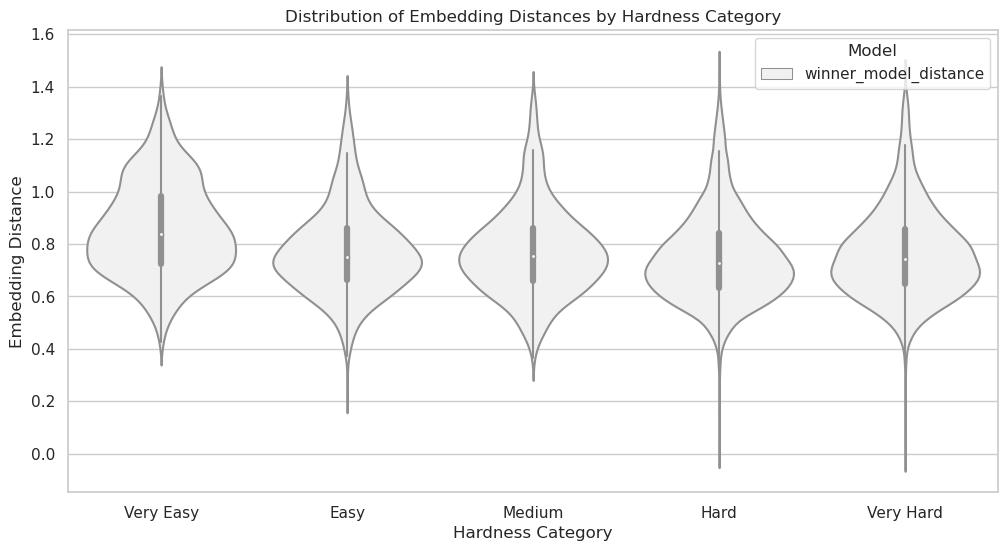

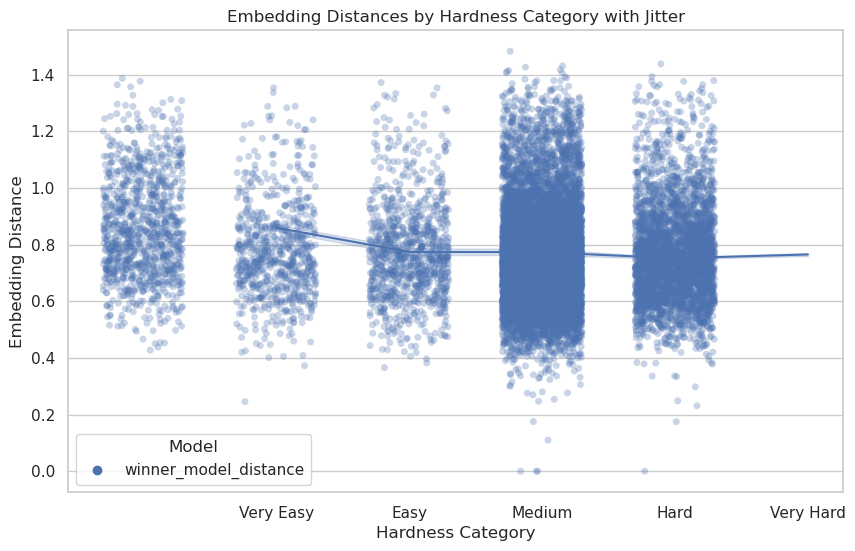

In [103]:
from scipy.spatial.distance import euclidean

# Map hardness categories to numerical values
hardness_mapping = {'Very Easy': 1, 'Easy': 2, 'Medium': 3, 'Hard': 4, 'Very Hard': 5}
conversation_and_topic_hardness_win['hardness_numeric'] = conversation_and_topic_hardness_win['hardness_cat'].map(hardness_mapping)

# Compute embedding distances for model A and model B responses
conversation_and_topic_hardness_win['model_a_distance'] = conversation_and_topic_hardness_win.apply(
    lambda row: euclidean(row['user_prompt_embedding'], row['model_a_response_embedding']), axis=1
)
conversation_and_topic_hardness_win['model_b_distance'] = conversation_and_topic_hardness_win.apply(
    lambda row: euclidean(row['user_prompt_embedding'], row['model_b_response_embedding']), axis=1
)

# Create 'winner_model_distance' column based on the winning model
conversation_and_topic_hardness_win['winner_model_distance'] = np.where(
    conversation_and_topic_hardness_win['winner_model'] == 'model_a', 
    conversation_and_topic_hardness_win['model_a_distance'], 
    conversation_and_topic_hardness_win['model_b_distance']
)

# Melt data for easier plotting (single melt for all plots)
distance_df = conversation_and_topic_hardness_win.melt(
    id_vars=['hardness_cat', 'hardness_numeric'],
    value_vars=['winner_model_distance'],
    var_name='Model',
    value_name='Embedding Distance'
)


# Violin Plot of Embedding Distances by Hardness Category
plt.figure(figsize=(12, 6))
sns.violinplot(data=distance_df, x='hardness_cat', y='Embedding Distance', hue='Model', color='white')
plt.title('Distribution of Embedding Distances by Hardness Category')
plt.xlabel('Hardness Category')
plt.ylabel('Embedding Distance')
plt.legend(title='Model')
plt.show()


# Jittered Strip Plot with Trend Line
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=distance_df,
    x='hardness_numeric', 
    y='Embedding Distance', 
    hue='Model',
    dodge=True, 
    jitter=0.3, 
    alpha=0.3
)
sns.lineplot(
    data=distance_df, 
    x='hardness_numeric', 
    y='Embedding Distance', 
    hue='Model', 
    markers=True, 
    legend=False,
    color='blue'
)
plt.title('Embedding Distances by Hardness Category with Jitter')
plt.xlabel('Hardness Category')
plt.ylabel('Embedding Distance')
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard'])
plt.legend(title='Model')
plt.show()

**Takeaways**

- Both the violin plot and jittered scatter plot show a stable median embedding distance across all hardness categories. This indicates that the model maintains a similar level of semantic closeness to user prompts, irrespective of question difficulty.
- In the violin plot, we see similar shapes and spread across categories, with distances concentrated between roughly 0.6 and 1.0. This suggests that the majority of responses are consistently within this range, regardless of the difficulty level. The scatter plot with jitter reinforces this by displaying a dense clustering around these values, confirming the consistency seen in the violin plot.
- The scatter plot trend line shows a slight downward slope as difficulty increases, suggesting a minimal reduction in embedding distance for harder questions. This might imply that as the questions become harder, the responses are slightly more aligned with the prompt embeddings, although the difference is subtle.
- Both plots show some responses with lower embedding distances across all categories. These outliers indicate instances where the response was less aligned with the prompt, potentially suggesting less relevant or contextually fitting answers.

### Key Observations and Takeaways With Topic & Hardness Dataset

- **What is the score distribution and win rate of each chatbot model in each different hardness level?**
The win rate distribution across hardness levels shows that GPT-4 consistently outperforms other models across almost all levels of difficulty, with the exception of "Very Easy" questions, where Claude-v1 achieves the highest win rate. For "Very Hard" questions, GPT-4 remains the top performer, followed by Claude-v1 and Claude-instant-v1. As the hardness decreases (from "Very Hard" to "Very Easy"), the performance differences among models become less pronounced, with a more balanced distribution of win rates among GPT-4, Claude-v1, GPT-3.5-turbo, and Gemini-3B. This suggests that while GPT-4 excels universally, Claude-v1 and other models are competitive at lower hardness levels.

- **How does the hardness score relate to the model that wins? Do some models perform consistently better on harder prompts compared to easier prompts, and vice versa?**
The results indicate that GPT-4 and Claude-v1 perform well across all levels of hardness, demonstrating strong generalization capabilities. GPT-4 dominates at higher hardness levels, while Claude-v1 shines particularly on "Very Easy" questions. Models like GPT-3.5-turbo and Gemini-3B show more variable performance, excelling on easier or medium-level prompts but falling behind on very hard questions. This indicates that while GPT-4 and Claude-v1 handle both easy and hard prompts effectively, some models are specialized for simpler tasks and struggle with increased difficulty.

- **What is the relation between the embedding distances of user prompt, model response, and the hardness score? Do higher hardness scores lead to responses with embeddings that are farther from the prompt embedding?**
Analysis of embedding distances shows that the distances remain relatively stable across all hardness levels, with most responses clustered between 0.6 and 1.0. Both the violin plot and jittered scatter plot indicate that hardness levels have little impact on the semantic closeness between user prompts and model responses. There is a slight downward trend in embedding distance as hardness increases, suggesting that responses to harder questions may be slightly more semantically aligned with the prompts, but this trend is minimal and does not indicate a significant correlation between hardness and embedding distance.

- **Do certain models demonstrate specialized strengths at particular hardness levels?**
Yes, some models perform well only at specific difficulty levels. GPT-4 and Claude-v1 are the most consistent performers across all hardness levels, whereas models like GPT-3.5-turbo and Gemini-3B excel primarily at "Easy" and "Medium" levels but do not maintain high performance on harder questions. This specialization indicates that GPT-4 and Claude-v1 are better suited for general use, while other models are effective for simpler tasks but less reliable on difficult prompts.

- **Do very easy and very hard prompts yield different winning models?**
On "Very Easy" prompts, Claude-v1 outperforms GPT-4, which is the opposite of the trend observed at higher hardness levels where GPT-4 dominates. This suggests that while GPT-4 is robust across most hardness categories, Claude-v1 is particularly effective for simpler tasks and achieves higher win rates on very easy prompts compared to more challenging ones.

- **How does the distribution of embedding distances change as hardness levels increase?**
The distribution of embedding distances remains consistent across hardness levels, with a dense clustering between 0.6 and 1.0. This indicates that the model responses maintain a similar level of semantic alignment with the user prompts, regardless of the difficulty level. Both the violin and scatter plots confirm that hardness has a negligible effect on the semantic closeness of model responses to the prompts.

- **Are there outliers in embedding distances, and do they vary across hardness levels?**
Yes, there are occasional outliers with lower embedding distances across all hardness levels. These responses indicate instances where the response was less aligned with the prompt’s intended meaning, potentially suggesting irrelevant or contextually less fitting answers. However, these outliers are distributed across all hardness levels and do not suggest a strong pattern related to question difficulty.

- **Does the hardness level impact the semantic alignment between the prompt and response embeddings?**
While there is a very slight downward trend in embedding distances as hardness levels increase, indicating a minor improvement in alignment for harder prompts, the effect is minimal. Both the violin and scatter plots show that the majority of responses are within a stable embedding distance range across all levels of hardness, suggesting that hardness has little impact on the semantic alignment of responses with prompts.

- **Which topics are most common, and do they align with specific hardness levels?**
The most frequent topics are creative writing, factual accuracy, and problem-solving/creativity. The average hardness scores for these top topics are 8.2, 7.8, and 6.9, respectively, suggesting that creative writing and factual accuracy, the two most common topics, are also among the harder topics. This indicates that popular topics in the dataset tend to be associated with higher hardness scores, suggesting a correlation between topic type and complexity.